# 1. preprocess (including removing doublet cells)

In [44]:
library(Seurat)
library(dplyr)
library(magrittr)
IRdisplay::display_html("<style> .container { width:95% !important; } </style>")
library("xlsx")
library("ggplot2")
library(grid)
library(reshape2)
library("scales")

In [39]:
cntl.data <-Read10X(data.dir = "/media/garret/New Volume/scRNAseq_data/Yoshiko/180725LHb/raw_gene_bc_matrices/mm10")
colnames(cntl.data) = paste0(colnames(cntl.data),"cntl")
cntl<- CreateSeuratObject(counts = cntl.data, min.cells = 3, min.features = 200, project = "10X_LHb")
cntl@meta.data$stim <- "cntl"

In [40]:
cntl_clean<-rownames(read.table(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/180725LHb/all_cells/gene2000_30/doublet/Final_nondoublets_groups_cntl.txt"))
cntl_doublet<-rownames(read.table(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/180725LHb/all_cells/gene2000_30/doublet/Final_doublets_groups_cntl.txt"))
doubletrate_cntl<-100*length(cntl_doublet)/(length(cntl_clean)+length(cntl_doublet))
doubletrate_cntl

[1] 4.16129

In [41]:
cntl<-subset(x=cntl,cells=cntl_clean)

In [42]:
stim.data <-Read10X(data.dir = "/media/garret/New Volume/scRNAseq_data/Yoshiko/180905LHb/raw_gene_bc_matrices/mm10")
colnames(stim.data) = paste0(colnames(stim.data),"stim")
stim<- CreateSeuratObject(counts = stim.data, min.cells = 3, min.features = 200, project = "10X_LHb")
stim@meta.data$stim <- "stim"

In [43]:
stim_clean<-rownames(read.table(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/180905LHb/all_cells/gene2000_30/doublet/Final_nondoublets_groups_stim.txt"))
stim<-subset(x=stim,cells=stim_clean)

In [44]:
stim_doublet<-rownames(read.table(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/180905LHb/all_cells/gene2000_30/doublet/Final_doublets_groups_stim.txt"))
doubletrate_stim<-100*length(stim_doublet)/(length(stim_clean)+length(stim_doublet))
doubletrate_stim

[1] 3.761349

In [45]:
#total doublet percentage
100*(length(cntl_doublet)+length(stim_doublet))/(length(cntl_clean)+length(cntl_doublet)+length(stim_clean)+length(stim_doublet))

[1] 3.961837

In [238]:
mito.features <- grep(pattern = "^mt-", x = rownames(x = cntl), value = TRUE)
percent.mito <- Matrix::colSums(x = GetAssayData(object = cntl, slot = 'counts')[mito.features, ]) / Matrix::colSums(x = GetAssayData(object = cntl, slot = 'counts'))
cntl[['percent.mito']] <- percent.mito


In [239]:
mito.features <- grep(pattern = "^mt-", x = rownames(x = stim), value = TRUE)
percent.mito <- Matrix::colSums(x = GetAssayData(object = stim, slot = 'counts')[mito.features, ]) / Matrix::colSums(x = GetAssayData(object = stim, slot = 'counts'))
stim[['percent.mito']] <- percent.mito

In [240]:
cntl <- subset(x = cntl, subset = nCount_RNA > 700 & nCount_RNA < 15000 & percent.mito < 0.20)
stim <- subset(x = stim, subset = nCount_RNA > 700 & nCount_RNA < 15000 & percent.mito < 0.20)

In [14]:
cntl<- NormalizeData(object = cntl,verbose = FALSE) 
stim<- NormalizeData(object = stim,verbose = FALSE) 

In [15]:
cntl<- FindVariableFeatures(object =cntl,selection.method = "vst", nfeatures = 2000, verbose = FALSE)
stim<- FindVariableFeatures(object =stim,selection.method = "vst", nfeatures = 2000, verbose = FALSE)

[1] 2000

[1] 2000

In [16]:
LHb.list<-objects()

In [17]:
LHb.list$cntl<-cntl

Warning message in LHb.list$cntl <- cntl:
“Coercing LHS to a list”

In [18]:
LHb.list$stim<-stim

# 2. Integration of multiple dataset

In [19]:
reference.list <- LHb.list[c("cntl","stim")]
LHb.anchors <- FindIntegrationAnchors(object.list = reference.list, dims = 1:30) 

Computing 2000 integration features
Scaling features for provided objects
Finding all pairwise anchors
Running CCA
Merging objects
Finding neighborhoods
Finding mutual nearest neighborhoods
	Found 10957 anchors
Filtering Anchors
	Retained 7307 anchors
Extracting within-dataset neighbors!


In [20]:
LHb.integrated <- IntegrateData(anchorset = LHb.anchors, dims = 1:30) 

Merging dataset 2 into 1
Extracting anchors for merged samples
Finding integration vectors
Finding integration vector weights
Integrating data


In [21]:
library(ggplot2)
library(cowplot)


Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



In [22]:
DefaultAssay(object = LHb.integrated) <- "integrated" # you can switch back and forth with RNA

In [23]:
LHb.integrated <- ScaleData(object = LHb.integrated, , vars.to.regress = c("nCount_RNA", "percent.mito"),verbose = FALSE)

In [24]:
LHb.integrated <- RunPCA(object = LHb.integrated, npcs = 30, verbose = FALSE)# npcs 50 default

In [25]:
LHb.integrated <- RunUMAP(object = LHb.integrated, reduction = "pca", dims = 1:30)

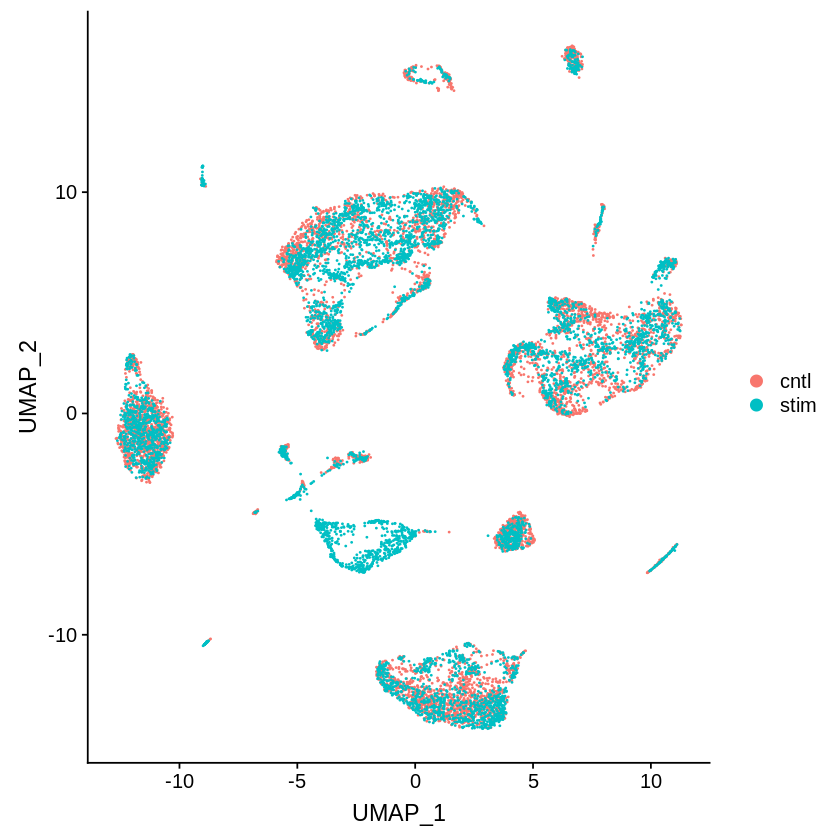

In [26]:
p1 <- DimPlot(object = LHb.integrated, reduction = "umap", group.by = "stim")
plot_grid(p1)

# integrated analysis

In [27]:
LHb.integrated <- FindNeighbors(object = LHb.integrated)

Computing nearest neighbor graph
Computing SNN


In [28]:
LHb.integrated <- FindClusters(LHb.integrated, resolution = 0.8, dims.use = 1:30)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 11878
Number of edges: 616759

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9034
Number of communities: 20
Elapsed time: 1 seconds


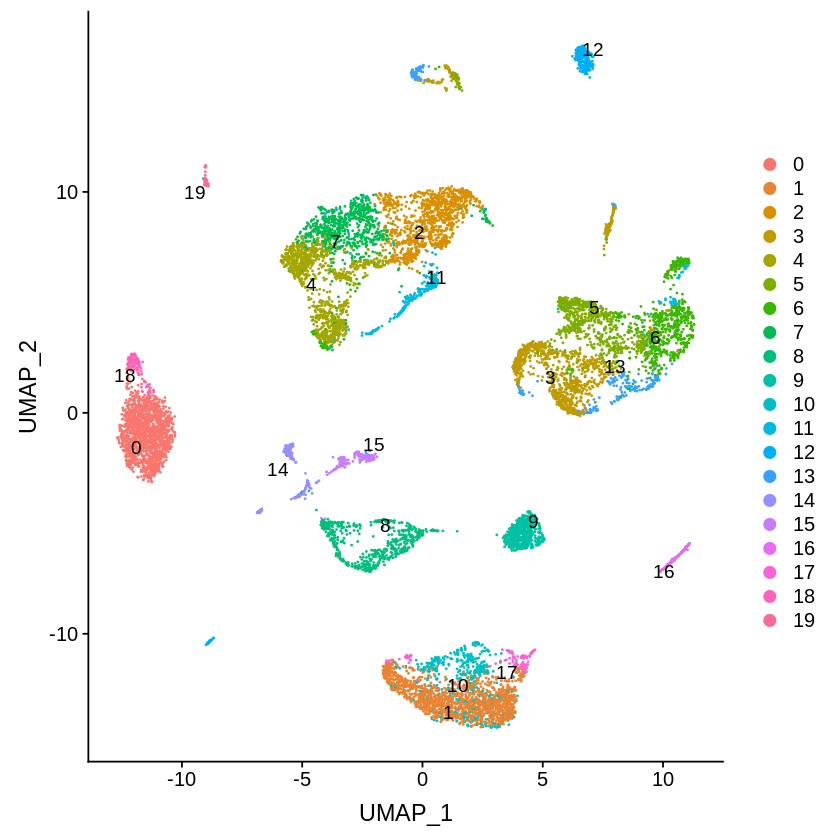

In [31]:
DimPlot(object = LHb.integrated, reduction = "umap", group.by = "integrated_snn_res.0.8", label = TRUE, repel = TRUE) 
ggsave(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/allcell_umap_number_2000_all20.pdf",width=10,height=10)

In [32]:
saveRDS(LHb.integrated, file = "/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/LHb_integrated.rds")

In [33]:
saveRDS(cntl, file = "/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/cntl.rds")
saveRDS(stim, file = "/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/stim.rds")

In [34]:
F<-FeaturePlot(object =LHb.integrated, features = c("Stmn2","Thy1","Aldoc","Aqp4","Tmem119","C1qc","Mog","Opalin","Pdgfra","Gpr17","Cldn5","Tagln","Vtn","Flt1","Spp1","Foxj1","Fam216b"))
ggsave(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/feature_all_genes_2000_30.pdf",width=10,height=10)

In [35]:
F<-FeaturePlot(object =LHb.integrated, features = c("Stmn2","Thy1","Aldoc","Aqp4"))
ggsave(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/feature_neuron_astrocyte_genes_2000_30.pdf",width=10,height=10)

In [36]:
#  microglia and oligo
F<-FeaturePlot(object =LHb.integrated, features =  c("Tmem119","C1qc","Mog","Opalin"))
ggsave(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/feature_microglia_Oligo_genes_2000_30.pdf",width=10,height=10)

In [37]:
#  OPC and mural and pericytes
F<-FeaturePlot(object =LHb.integrated, features = c("Pdgfra","Gpr17","Cldn5","Tagln","Flt1","Vtn"))
ggsave(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/feature_OPC_Pericytes_genes_2000_30.pdf",width=10,height=10)

In [38]:
#  eppen
F<-FeaturePlot(object =LHb.integrated, features = c("Foxj1","Fam216b"))
ggsave(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/feature_eppen_genes_2000_30.pdf",width=10,height=10)

In [ ]:
# you can start from below for downstream analysis

In [11]:
LHb.integrated<-readRDS(file = "/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/LHb_integrated.rds")
cntl<-readRDS(file = "/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/cntl.rds")
stim<-readRDS(file = "/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/stim.rds")

In [32]:
median(LHb.integrated@meta.data$nFeature_RNA)
median(LHb.integrated@meta.data$nCount_RNA)

[1] 1000.5

[1] 2029.5

# assgin clusters to cell types

In [12]:
new.ident <- c("Astrocyte1","Oligo1","Neuron1","Neuron2","Neuron3","Neuron4","Neuron5","Neuron6","OPC1","OPC2","Oligo2","Neuron7","Microglia","Neuron8","Mural","Endothelial","OPC3","Oligo3","Astrocyte2","Epen")
names(x = new.ident) <- levels(x =LHb.integrated)
LHb.integrated<- RenameIdents(object =LHb.integrated, new.ident)

In [5]:
color<-c("#19647e","#ffc857","#9B0C1E","#9B0C1E","#9B0C1E","#9B0C1E","#9B0C1E","#9B0C1E","#4b3f72","#4b3f72","#ffc857","#9B0C1E","#676833","#9B0C1E","#b7b7b7","#E8C6C7","#4b3f72","#ffc857","#19647e","#B99A69")

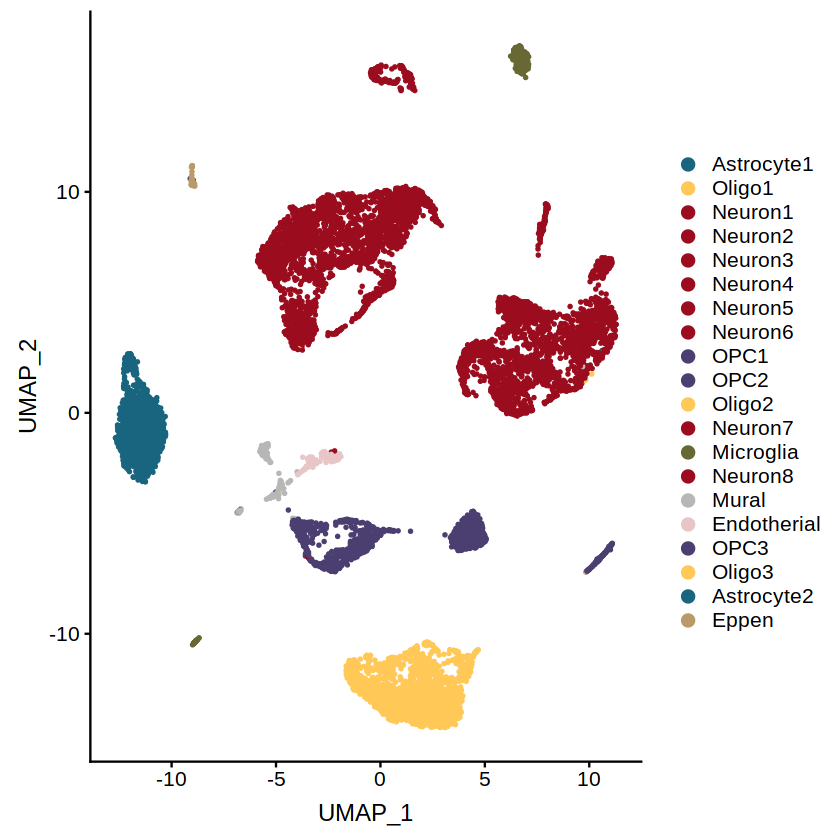

In [6]:
DimPlot(object = LHb.integrated, reduction = "umap", label = FALSE, repel = TRUE,cols=color,label.size = 12,pt.size=0.5) 
ggsave(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/allcell_umap_name_2000_30_nolabel2.pdf",width=10,height=7)

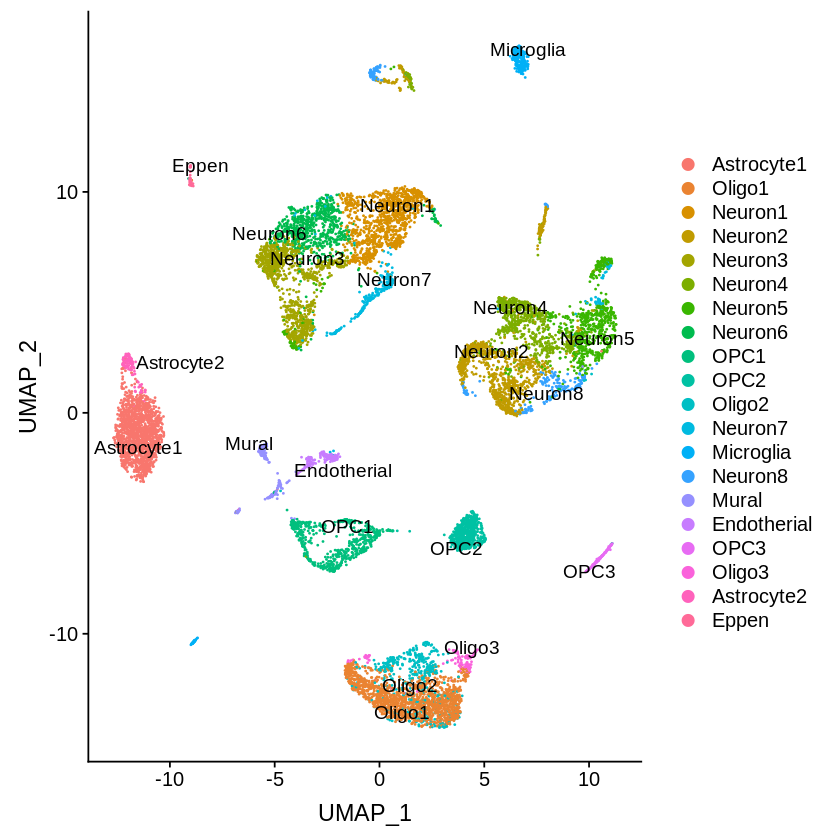

In [87]:
DimPlot(object = LHb.integrated, reduction = "umap", label = TRUE, repel = TRUE) 
ggsave(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/allcell_umap_name_2000_30.pdf",width=10,height=10)

# Cell type analysis in each condition

In [13]:
for (i in 1:length(new.ident)){
assign(paste(new.ident[i],"_barcode",sep=""),colnames(LHb.integrated@assays$RNA@data[,which(Idents(object=LHb.integrated) %in% new.ident[i])]))# this gives all barcodes in cluster
assign(paste(new.ident[i],"_barcode_cntl",sep=""),intersect(colnames(cntl@assays$RNA@data),eval(parse(text = paste(new.ident[i],"_barcode",sep="")))))
assign(paste(new.ident[i],"_barcode_stim",sep=""),intersect(colnames(stim@assays$RNA@data),eval(parse(text = paste(new.ident[i],"_barcode",sep="")))))}


In [43]:
pdf(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/cluster_tree.pdf",width=20,height=8,paper='special') 
#https://www.rdocumentation.org/packages/ape/versions/5.2/topics/plot.phylo
LHb.integrated <- BuildClusterTree(LHb.integrated, verbose = FALSE, reorder = FALSE)
plot(LHb.integrated@tools$BuildClusterTree, type = "phylogram", edge.color = "black", edge.width = 4,edge.lty = 1, srt = 0, label.offset = 10, direction = "downwards", tip.color = "black")
dev.off()

png 
  2

In [14]:
# barcode for simpler cell type
Neuron_barcode_cntl<-c(Neuron1_barcode_cntl,Neuron2_barcode_cntl,Neuron3_barcode_cntl,Neuron4_barcode_cntl,Neuron5_barcode_cntl,Neuron6_barcode_cntl,Neuron7_barcode_cntl,Neuron8_barcode_cntl)
Neuron_barcode_stim<-c(Neuron1_barcode_stim,Neuron2_barcode_stim,Neuron3_barcode_stim,Neuron4_barcode_stim,Neuron5_barcode_stim,Neuron6_barcode_stim,Neuron7_barcode_stim,Neuron8_barcode_stim)

Astrocyte_barcode_cntl<-c(Astrocyte1_barcode_cntl,Astrocyte2_barcode_cntl)
Astrocyte_barcode_stim<-c(Astrocyte1_barcode_stim,Astrocyte2_barcode_stim)

Oligo_barcode_cntl<-c(Oligo1_barcode_cntl,Oligo2_barcode_cntl,Oligo3_barcode_cntl)
Oligo_barcode_stim<-c(Oligo1_barcode_stim,Oligo2_barcode_stim,Oligo3_barcode_stim)

OPC_barcode_cntl<-c(OPC1_barcode_cntl,OPC2_barcode_cntl,OPC3_barcode_cntl)
OPC_barcode_stim<-c(OPC1_barcode_stim,OPC2_barcode_stim,OPC3_barcode_stim)

In [65]:
#these are used for analyzing on neuronal cells ~figure2
saveRDS(Neuron_barcode_cntl, file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/Neuron_cntl_id.rds")
saveRDS(Neuron_barcode_stim, file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/Neuron_stim_id.rds")


# UMI plot

In [15]:
Neuron_barcode<-c(Neuron_barcode_cntl,Neuron_barcode_stim)
Astrocyte_barcode<-c(Astrocyte_barcode_cntl,Astrocyte_barcode_stim)
Oligo_barcode<-c(Oligo_barcode_cntl,Oligo_barcode_stim)
Microglia_barcode<-c(Microglia_barcode_cntl,Microglia_barcode_stim)
OPC_barcode<-c(OPC_barcode_cntl,OPC_barcode_stim)
Mural_barcode<-c(Mural_barcode_cntl,Mural_barcode_stim)
Endothelial_barcode<-c(Endothelial_barcode_cntl,Endothelial_barcode_stim)
Epen_barcode<-c(Epen_barcode_cntl,Epen_barcode_stim)

In [38]:
length(Microglia_barcode)/11878
length(Mural_barcode)/11878
length(Endotherial_barcode)/11878
length(Eppen_barcode)/11878

[1] 0.02550935

[1] 0.02071056

[1] 0.01363866

[1] 0.003535949

In [9]:
type<-numeric()
for (i in 1:dim(LHb.integrated@meta.data)[1]){
    if(rownames(LHb.integrated@meta.data)[i] %in% Neuron_barcode){type[i]<-"Neuron"}
    else if(rownames(LHb.integrated@meta.data)[i] %in% Astrocyte_barcode){type[i]<-"Astrocyte"}
         else if(rownames(LHb.integrated@meta.data)[i] %in% Oligo_barcode){type[i]<-"Oligo"}
              else if(rownames(LHb.integrated@meta.data)[i] %in% Microglia_barcode){type[i]<-"Microglia"}
                   else if(rownames(LHb.integrated@meta.data)[i] %in% Mural_barcode){type[i]<-"Mural"}
                        else if(rownames(LHb.integrated@meta.data)[i] %in% Endothelial_barcode){type[i]<-"Endothelial"}
                             else if(rownames(LHb.integrated@meta.data)[i] %in% Epen_barcode){type[i]<-"Epen"}
                                 else if(rownames(LHb.integrated@meta.data)[i] %in% OPC_barcode){type[i]<-"OPC"}
                                 else{type[i]<-"NA"}
}
LHb.integrated@meta.data$type<-type                    

In [10]:
LHb.integrated@meta.data$type<-factor(LHb.integrated@meta.data$type,levels=c("Neuron","Oligo","Astrocyte","OPC","Microglia","Mural","Endothelial","Epen"))

In [11]:
colors<-c("Astrocyte"="#19647e","Oligo"="#ffc857","Neuron"="#9B0C1E","OPC"="#4b3f72","Oligo"="#ffc857","Microglia"="#676833","Mural"="#b7b7b7","Endothelial"="#E8C6C7","Epen"="#B99A69")

In [12]:
subset_meta<-subset(LHb.integrated@meta.data,type=="Neuron"|type=="Astrocyte"|type=="Oligo"|type=="Mural"|type=="OPC"|type=="Microglia"|type=="Endothelial"|type=="Epen")

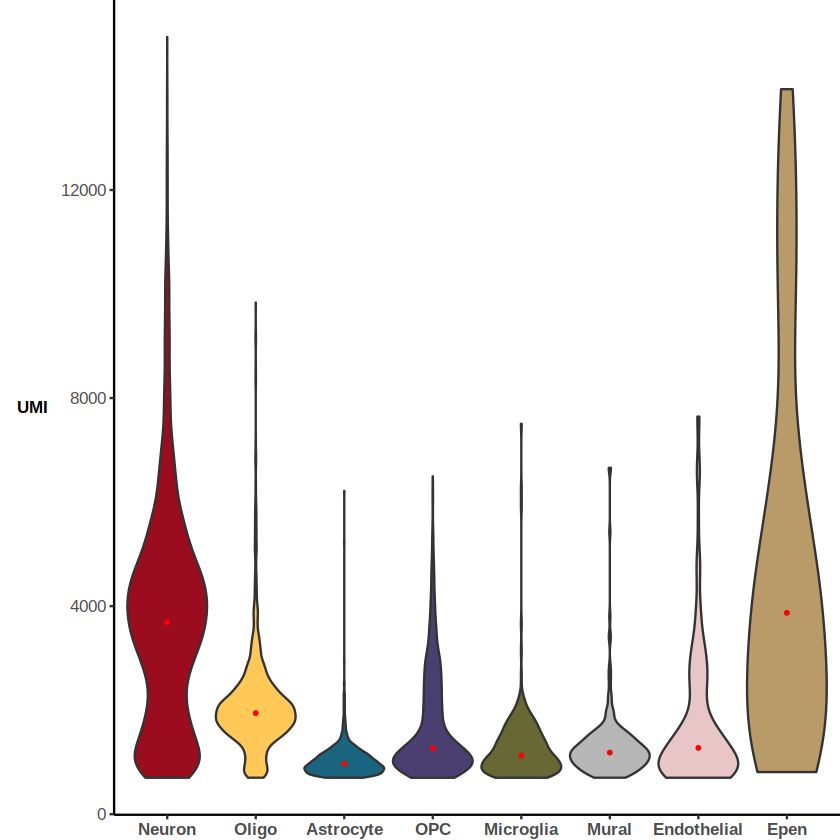

In [13]:
ggplot(subset_meta,aes_string(x="type",y="nCount_RNA",fill="type"))+geom_violin(scale = "width")+scale_fill_manual(values=colors)+
stat_summary(fun.y=median, geom="point", size=0.6, color="red")+ylab("UMI")+ 
theme(axis.title.x=element_blank(),
,axis.text.y=element_text(size=10),axis.title.y=element_text(size=10,angle=0,face="bold",margin = margin(t = 10, r = 8, b = 0, l = 10),vjust=0.5),axis.text.x=element_text(size=10,face="bold")
,axis.title=element_text(size=15,face="bold"),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"),legend.position="none",plot.margin = unit(c(0, 0,0, 0), "cm"))
ggsave(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/UMI_celltype.pdf",height=6, width=10 , paper = "letter")

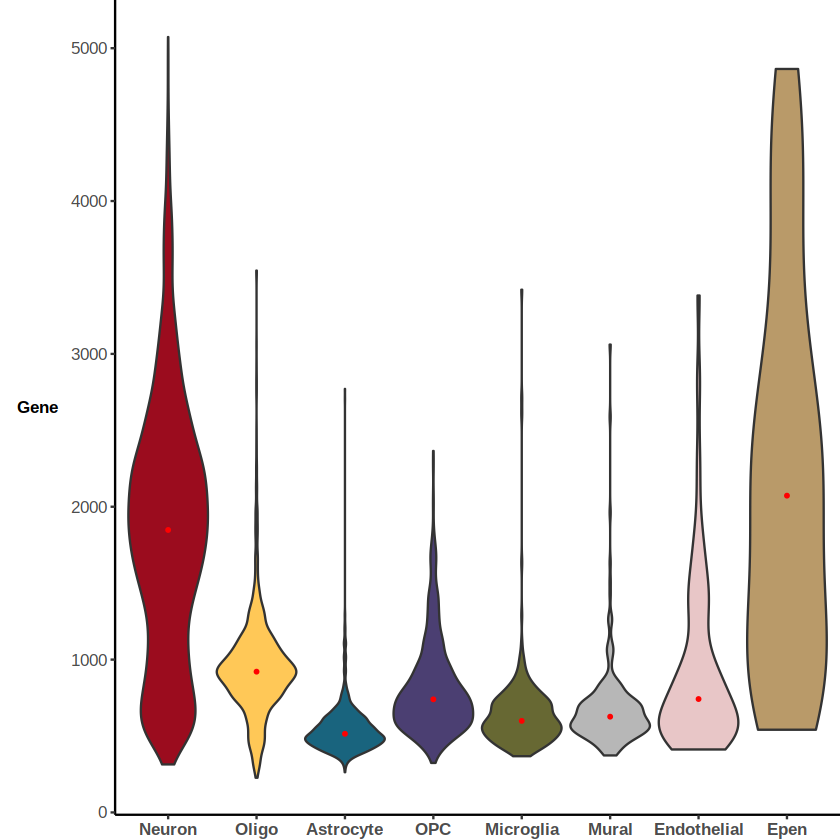

In [15]:
ggplot(subset_meta,aes_string(x="type",y="nFeature_RNA",fill="type"))+geom_violin(scale = "width")+scale_fill_manual(values=colors)+
stat_summary(fun.y=median, geom="point", size=0.6, color="red")+ylab("Gene")+ 
theme(axis.title.x=element_blank(),
,axis.text.y=element_text(size=10),axis.title.y=element_text(size=10,angle=0,face="bold",margin = margin(t = 10, r = 8, b = 0, l = 10),vjust=0.5),axis.text.x=element_text(size=10,face="bold")
,axis.title=element_text(size=15,face="bold"),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"),legend.position="none",plot.margin = unit(c(0, 0,0, 0), "cm"))
ggsave(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/gene_celltype.pdf",height=6, width=10 , paper = "letter")

# violinplot for canonical markers

In [12]:
Cell_type<-rev(c("Oligo3","Oligo1","Oligo2","Neuron4","Neuron2","Neuron8","Neuron3","Neuron6","Neuron1","Neuron5","Neuron7","Microglia","Epen","Astrocyte1","Astrocyte2","OPC3","OPC1","OPC2","Mural","Endothelial"))
gene_list<-c("Mog" ,"Opalin" ,"Stmn2" ,"Thy1" ,"Tmem119" ,"C1qc","Foxj1","Fam216b","Slc4a4","Ntsr2","Pdgfra" ,"Gpr17","Ccnd1","Tagln" ,"Cldn5" ,"Flt1")

In [13]:
Cell_number<- data.frame(Date=as.Date(character()),File=character(),User=character(),stringsAsFactors=FALSE)

for (i in 1:length(Cell_type)){
L<-length(eval(parse(text = paste(Cell_type[i],"_barcode",sep=""))))

Cell_number_t<- data.frame("type" =c(rep(Cell_type[i],L)))
#used normalized uncorrected data
for (p in 1:length(gene_list)){
Cell_number_t[gene_list[p]]<-as.vector(LHb.integrated@assays$RNA@data[gene_list[p],eval(parse(text = paste(Cell_type[i],"_barcode",sep="")))])
}
Cell_number<-rbind(Cell_number_t,Cell_number)}

as.factor(Cell_number$type)

[1] Oligo3      Oligo3      Oligo3      Oligo3      Oligo3      Oligo3     
    [7] Oligo3      Oligo3      Oligo3      Oligo3      Oligo3      Oligo3     
   [13] Oligo3      Oligo3      Oligo3      Oligo3      Oligo3      Oligo3     
   [19] Oligo3      Oligo3      Oligo3      Oligo3      Oligo3      Oligo3     
   [25] Oligo3      Oligo3      Oligo3      Oligo3      Oligo3      Oligo3     
   [31] Oligo3      Oligo3      Oligo3      Oligo3      Oligo3      Oligo3     
   [37] Oligo3      Oligo3      Oligo3      Oligo3      Oligo3      Oligo3     
   [43] Oligo3      Oligo3      Oligo3      Oligo3      Oligo3      Oligo3     
   [49] Oligo3      Oligo3      Oligo3      Oligo3      Oligo3      Oligo3     
   [55] Oligo3      Oligo3      Oligo3      Oligo3      Oligo3      Oligo3     
   [61] Oligo3      Oligo3      Oligo3      Oligo3      Oligo3      Oligo3     
   [67] Oligo3      Oligo3      Oligo3      Oligo3      Oligo3      Oligo3     
   [73] Oligo3      Oligo3      Oligo3      Oligo3      Oligo3      Oligo3     
   [79] Oligo3      Oligo3      Oligo3      Oligo3      Oligo3      Oligo3     
   [85] Oligo3      Oligo3      Oligo3      Oligo3      Oligo3      Oligo3     
   [91] Oligo3      Oligo3      Oligo3      Oligo3      Oligo3      Oligo3     
   [97] Oligo3      Oligo3      Oligo3      Oligo3      Oligo3      Oligo3     
  [103] Oligo3      Oligo3      Oligo3      Oligo3      Oligo3      Oligo3     
  [109] Oligo3      Oligo3      Oligo3      Oligo3      Oligo3      Oligo3     
  [115] Oligo3      Oligo3      Oligo3      Oligo3      Oligo3      Oligo3     
  [121] Oligo3      Oligo3      Oligo3      Oligo3      Oligo3      Oligo3     
  [127] Oligo3      Oligo1      Oligo1      Oligo1      Oligo1      Oligo1     
  [133] Oligo1      Oligo1      Oligo1      Oligo1      Oligo1      Oligo1     
  [139] Oligo1      Oligo1      Oligo1      Oligo1      Oligo1      Oligo1     
  [145] Oligo1      Oligo1      Oligo1      Oligo1      Oligo1      Oligo1     
  [151] Oligo1      Oligo1      Oligo1      Oligo1      Oligo1      Oligo1     
  [157] Oligo1      Oligo1      Oligo1      Oligo1      Oligo1      Oligo1     
  [163] Oligo1      Oligo1      Oligo1      Oligo1      Oligo1      Oligo1     
  [169] Oligo1      Oligo1      Oligo1      Oligo1      Oligo1      Oligo1     
  [175] Oligo1      Oligo1      Oligo1      Oligo1      Oligo1      Oligo1     
  [181] Oligo1      Oligo1      Oligo1      Oligo1      Oligo1      Oligo1     
  [187] Oligo1      Oligo1      Oligo1      Oligo1      Oligo1      Oligo1     
  [193] Oligo1      Oligo1      Oligo1      Oligo1      Oligo1      Oligo1     
  [199] Oligo1      Oligo1      Oligo1      Oligo1      Oligo1      Oligo1     
  [205] Oligo1      Oligo1      Oligo1      Oligo1      Oligo1      Oligo1     
  [211] Oligo1      Oligo1      Oligo1      Oligo1      Oligo1      Oligo1     
  [217] Oligo1      Oligo1      Oligo1      Oligo1      Oligo1      Oligo1     
  [223] Oligo1      Oligo1      Oligo1      Oligo1      Oligo1      Oligo1     
  [229] Oligo1      Oligo1      Oligo1      Oligo1      Oligo1      Oligo1     
  [235] Oligo1      Oligo1      Oligo1      Oligo1      Oligo1      Oligo1     
  [241] Oligo1      Oligo1      Oligo1      Oligo1      Oligo1      Oligo1     
  [247] Oligo1      Oligo1      Oligo1      Oligo1      Oligo1      Oligo1     
  [253] Oligo1      Oligo1      Oligo1      Oligo1      Oligo1      Oligo1     
  [259] Oligo1      Oligo1      Oligo1      Oligo1      Oligo1      Oligo1     
  [265] Oligo1      Oligo1      Oligo1      Oligo1      Oligo1      Oligo1     
  [271] Oligo1      Oligo1      Oligo1      Oligo1      Oligo1      Oligo1     
  [277] Oligo1      Oligo1      Oligo1      Oligo1      Oligo1      Oligo1     
  [283] Oligo1      Oligo1      Oligo1      Oligo1      Oligo1      Oligo1     
  [289] Oligo1      Oligo1      Oligo1      Oligo1      Oligo1      Oligo1     
  [295] Oligo1      Oligo1      Oligo1      Oligo1      Oligo1      Oligo1     
  [3

In [15]:
colors<-c("#ffc857","#ffc857","#ffc857","#9B0C1E","#9B0C1E","#9B0C1E","#9B0C1E","#9B0C1E","#9B0C1E","#9B0C1E","#9B0C1E","#676833","#B99A69","#19647e","#19647e","#4b3f72","#4b3f72","#4b3f72","#b7b7b7","#E8C6C7")

In [16]:
for (k in 1:length(gene_list))
    {
if (k==length(gene_list)){
assign(paste("P",k,sep=""),ggplot(Cell_number,aes_string(x="type",y=gene_list[k],fill="type"))+geom_violin(scale = "width")+scale_fill_manual(values=colors)
+stat_summary(fun.y=median, geom="point", size=0.6, color="red")+ylab(gene_list[k])+ theme(axis.title.x=element_blank(),
,axis.text.y=element_text(size=5),axis.title.y=element_text(size=6,angle=0,face="bold",margin = margin(t = 10, r = 8, b = 0, l = 10),vjust=0.5),axis.text.x=element_text(size=5,face="bold")
,axis.title=element_text(size=4,face="bold"),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"),legend.position="none",plot.margin = unit(c(0, 0,0, 0), "cm")))}
else{
assign(paste("P",k,sep=""),ggplot(Cell_number,aes_string(x="type",y=gene_list[k],fill="type"))+geom_violin(scale = "width")+scale_fill_manual(values=colors)
+stat_summary(fun.y=median, geom="point", size=0.6, color="red")+ylab(gene_list[k])+ theme(axis.title.x=element_blank(),
axis.text.x=element_blank(),axis.text.y=element_text(size=5),axis.title.y=element_text(size=6,angle=0,face="bold",margin = margin(t = 10, r = 8, b = 0, l = 10),vjust=0.5),axis.ticks.x=element_blank(),axis.text=element_text(size=5)
,axis.title=element_text(size=4,face="bold"),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"),legend.position="none",plot.margin = unit(c(0, 0,0, 0), "cm")))}

}

In [122]:
merge<-list()
for (i in length(gene_list):1){   
       if (length(merge)==0){
        merge<-ggplotGrob(eval(parse(text=paste("P",i,sep = ""))))}else{merge<-rbind(ggplotGrob(eval(parse(text=paste("P",i,sep = "")))),merge,size = "last")}}

#all genes
pdf(paste("/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/stackplotviolin_all_clusters_markers4",".png",sep=""),height=6, width=50 , paper = "letter")
grid.newpage()
grid.draw(merge)
dev.off()

png 
  2

# conserved markers for clusters/class

In [16]:
Idents(LHb.integrated)<-(gsub('[0-9]+', '', Idents(LHb.integrated)))
# for other analysis you may need to bring the identity back to the original

In [17]:
Cell_type<-c("Neuron","Astrocyte","Oligo","Microglia","OPC","Mural","Endothelial","Epen")

In [18]:
#used for paper, HB correction
for (i in 1:length(Cell_type)){
one.markers <- FindConservedMarkers(LHb.integrated, ident.1 = Cell_type[i], grouping.var = "stim", print.bar = FALSE)

A<-rowSums(as.matrix(LHb.integrated@assays$RNA@data))
A<-A[A>0]
B<-as.data.frame(A)
B<-rownames(B)
genes<-B
one.markers$cntl_p_val_adjust<-one.markers$cntl_p_val*length(genes)
one.markers$stim_p_val_adjust<-one.markers$stim_p_val*length(genes)
one.markers<-subset(one.markers,cntl_p_val_adjust<0.05 & stim_p_val_adjust<0.05 & cntl_avg_logFC>0 & stim_avg_logFC>0)
one.markers<-one.markers[order(-one.markers["stim_avg_logFC"]),]
write.xlsx(one.markers,file=(paste("/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/conserved_markers_type/",Cell_type[i],"_gene.xlsx",sep="")))}

Testing Neuron_stim vs Oligo_stim, Astrocyte_stim, Mural_stim, OPC_stim, Microglia_stim, Endothelial_stim, Epen_stim

Testing Neuron_cntl vs Astrocyte_cntl, Oligo_cntl, Microglia_cntl, OPC_cntl, Endothelial_cntl, Epen_cntl, Mural_cntl

Testing Astrocyte_stim vs Oligo_stim, Neuron_stim, Mural_stim, OPC_stim, Microglia_stim, Endothelial_stim, Epen_stim

Testing Astrocyte_cntl vs Neuron_cntl, Oligo_cntl, Microglia_cntl, OPC_cntl, Endothelial_cntl, Epen_cntl, Mural_cntl

Testing Oligo_stim vs Neuron_stim, Astrocyte_stim, Mural_stim, OPC_stim, Microglia_stim, Endothelial_stim, Epen_stim

Testing Oligo_cntl vs Astrocyte_cntl, Neuron_cntl, Microglia_cntl, OPC_cntl, Endothelial_cntl, Epen_cntl, Mural_cntl

Testing Microglia_stim vs Oligo_stim, Neuron_stim, Astrocyte_stim, Mural_stim, OPC_stim, Endothelial_stim, Epen_stim

Testing Microglia_cntl vs Astrocyte_cntl, Neuron_cntl, Oligo_cntl, OPC_cntl, Endothelial_cntl, Epen_cntl, Mural_cntl

Testing OPC_stim vs Oligo_stim, Neuron_stim, Astrocyte_s

In [242]:
#conserved markers per cluster
Cell_type<-c("Astrocyte1","Oligo1","Neuron1","Neuron2","Neuron3","Neuron4","Neuron5","Neuron6","OPC1","OPC2","Oligo2","Neuron7","Microglia","Neuron8","Mural","Endotherial","OPC3","Oligo3","Astrocyte2","Eppen")
for (i in 1:length(Cell_type)){
one.markers <- FindConservedMarkers(LHb.integrated, ident.1 = Cell_type[i], grouping.var = "stim",print.bar = FALSE)
one.markers<-subset(one.markers,stim_p_val_adj<0.05 & cntl_p_val_adj<0.05 & cntl_avg_logFC>0 & stim_avg_logFC>0)
sort_marker<-one.markers[order(-one.markers["stim_avg_logFC"]),]
write.xlsx(sort_marker,file=(paste("/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/conserved_markers/",Cell_type[i],"_gene.xlsx",sep="")))}

Testing Astrocyte1_stim vs Oligo1_stim, Oligo3_stim, Oligo2_stim, Neuron6_stim, Neuron3_stim, Neuron1_stim, Neuron7_stim, Neuron8_stim, Neuron5_stim, Astrocyte2_stim, Neuron2_stim, Neuron4_stim, Mural_stim, OPC1_stim, Microglia_stim, OPC2_stim, Endotherial_stim, Eppen_stim, OPC3_stim

Testing Astrocyte1_cntl vs Astrocyte2_cntl, Neuron8_cntl, Neuron5_cntl, Oligo1_cntl, Oligo2_cntl, Neuron6_cntl, Neuron3_cntl, Neuron1_cntl, Neuron7_cntl, Neuron4_cntl, Neuron2_cntl, Microglia_cntl, OPC2_cntl, OPC1_cntl, Oligo3_cntl, OPC3_cntl, Endotherial_cntl, Eppen_cntl, Mural_cntl

Testing Oligo1_stim vs Oligo3_stim, Oligo2_stim, Neuron6_stim, Neuron3_stim, Neuron1_stim, Neuron7_stim, Neuron8_stim, Neuron5_stim, Astrocyte1_stim, Astrocyte2_stim, Neuron2_stim, Neuron4_stim, Mural_stim, OPC1_stim, Microglia_stim, OPC2_stim, Endotherial_stim, Eppen_stim, OPC3_stim

Testing Oligo1_cntl vs Astrocyte1_cntl, Astrocyte2_cntl, Neuron8_cntl, Neuron5_cntl, Oligo2_cntl, Neuron6_cntl, Neuron3_cntl, Neuron1_cntl, Ne

Testing Mural_cntl vs Astrocyte1_cntl, Astrocyte2_cntl, Neuron8_cntl, Neuron5_cntl, Oligo1_cntl, Oligo2_cntl, Neuron6_cntl, Neuron3_cntl, Neuron1_cntl, Neuron7_cntl, Neuron4_cntl, Neuron2_cntl, Microglia_cntl, OPC2_cntl, OPC1_cntl, Oligo3_cntl, OPC3_cntl, Endotherial_cntl, Eppen_cntl

Testing Endotherial_stim vs Oligo1_stim, Oligo3_stim, Oligo2_stim, Neuron6_stim, Neuron3_stim, Neuron1_stim, Neuron7_stim, Neuron8_stim, Neuron5_stim, Astrocyte1_stim, Astrocyte2_stim, Neuron2_stim, Neuron4_stim, Mural_stim, OPC1_stim, Microglia_stim, OPC2_stim, Eppen_stim, OPC3_stim

Testing Endotherial_cntl vs Astrocyte1_cntl, Astrocyte2_cntl, Neuron8_cntl, Neuron5_cntl, Oligo1_cntl, Oligo2_cntl, Neuron6_cntl, Neuron3_cntl, Neuron1_cntl, Neuron7_cntl, Neuron4_cntl, Neuron2_cntl, Microglia_cntl, OPC2_cntl, OPC1_cntl, Oligo3_cntl, OPC3_cntl, Eppen_cntl, Mural_cntl

Testing OPC3_stim vs Oligo1_stim, Oligo3_stim, Oligo2_stim, Neuron6_stim, Neuron3_stim, Neuron1_stim, Neuron7_stim, Neuron8_stim, Neuron5_stim

heatmap

In [22]:
Oligo<-read.xlsx2(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/conserved_markers_type/Oligo_gene.xlsx",sheetIndex=1)
Oligo$stim_avg_logFC<-as.numeric(paste(Oligo$stim_avg_logFC))
Oligo<-subset(Oligo,stim_avg_logFC > 0.5)
Neuron<-read.xlsx2(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/conserved_markers_type/Neuron_gene.xlsx",sheetIndex=1)
Neuron$stim_avg_logFC<-as.numeric(paste(Neuron$stim_avg_logFC))
Neuron<-subset(Neuron,stim_avg_logFC > 0.5)
Microglia<-read.xlsx2(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/conserved_markers_type/Microglia_gene.xlsx",sheetIndex=1)
Microglia$stim_avg_logFC<-as.numeric(paste(Microglia$stim_avg_logFC))
Microglia<-subset(Microglia,stim_avg_logFC > 0.5)
Epen<-read.xlsx2(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/conserved_markers_type/Epen_gene.xlsx",sheetIndex=1)
Epen$stim_avg_logFC<-as.numeric(paste(Epen$stim_avg_logFC))
Epen<-subset(Epen,stim_avg_logFC > 0.5)
Astrocyte<-read.xlsx2(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/conserved_markers_type/Astrocyte_gene.xlsx",sheetIndex=1)
Astrocyte$stim_avg_logFC<-as.numeric(paste(Astrocyte$stim_avg_logFC))
Astrocyte<-subset(Astrocyte,stim_avg_logFC > 0.5)
OPC<-read.xlsx2(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/conserved_markers_type/OPC_gene.xlsx",sheetIndex=1)
OPC$stim_avg_logFC<-as.numeric(paste(OPC$stim_avg_logFC))
OPC<-subset(OPC,stim_avg_logFC > 0.5)
Mural<-read.xlsx2(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/conserved_markers_type/Mural_gene.xlsx",sheetIndex=1)
Mural$stim_avg_logFC<-as.numeric(paste(Mural$stim_avg_logFC))
Mural<-subset(Mural,stim_avg_logFC > 0.5)
Endothelial<-read.xlsx2(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/conserved_markers_type/Endothelial_gene.xlsx",sheetIndex=1)
Endothelial$stim_avg_logFC<-as.numeric(paste(Endothelial$stim_avg_logFC))
Endothelial<-subset(Endothelial,stim_avg_logFC > 0.5)

In [23]:
all_genes<-c(as.character(Neuron[,1]),as.character(Oligo[,1]),as.character(Astrocyte[,1]),as.character(OPC[,1]),as.character(Microglia[,1]),as.character(Mural[,1]),as.character(Endothelial[,1]),as.character(Epen[,1]))
length(all_genes)

[1] 1194

In [3]:
#all DEG number
Oligo<-read.xlsx2(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/conserved_markers_type/Oligo_gene.xlsx",sheetIndex=1)
dim(Oligo)[1]
Neuron<-read.xlsx2(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/conserved_markers_type/Neuron_gene.xlsx",sheetIndex=1)
dim(Neuron)[1]
Microglia<-read.xlsx2(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/conserved_markers_type/Microglia_gene.xlsx",sheetIndex=1)
dim(Microglia)[1]
Epen<-read.xlsx2(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/conserved_markers_type/Epen_gene.xlsx",sheetIndex=1)
dim(Epen)[1]
Astrocyte<-read.xlsx2(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/conserved_markers_type/Astrocyte_gene.xlsx",sheetIndex=1)
dim(Astrocyte)[1]
OPC<-read.xlsx2(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/conserved_markers_type/OPC_gene.xlsx",sheetIndex=1)
dim(OPC)[1]
Mural<-read.xlsx2(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/conserved_markers_type/Mural_gene.xlsx",sheetIndex=1)
dim(Mural)[1]
Endothelial<-read.xlsx2(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/conserved_markers_type/Endothelial_gene.xlsx",sheetIndex=1)
dim(Endothelial)[1]


[1] 147

[1] 405

[1] 132

[1] 209

[1] 89

[1] 81

[1] 124

[1] 225

In [26]:
dim(Oligo)[1]+dim(Neuron)[1]+dim(Microglia)[1]+dim(Epen)[1]+dim(Astrocyte)[1]+dim(OPC)[1]+dim(Mural)[1]+dim(Endothelial)[1]


[1] 1412

In [24]:
select<-numeric()
for (i in 1:length(all_genes)){
    if(sum(all_genes==all_genes[i])==1){
        select<-c(select,i)}else{select<-select}
    }

In [25]:
Genes<-rev(unique(all_genes))

Genes<-factor(Genes,levels=Genes)
order<-c(Neuron_barcode,Oligo_barcode,Astrocyte_barcode,OPC_barcode,Microglia_barcode,Mural_barcode,Endothelial_barcode,Epen_barcode)
order<-factor(order,levels=order)
Hb.data<-LHb.integrated@assays$RNA@data[Genes,order]

In [26]:
Hb.data<-t(scale(t(as.matrix(Hb.data))))
levels(rownames(Hb.data))<-levels(Genes)
levels(colnames(Hb.data))<-levels(order)
test.m <- melt(Hb.data)

In [37]:
length(Neuron_barcode)
length(c(Neuron_barcode,Astrocyte_barcode))
length(c(Neuron_barcode,Astrocyte_barcode,Oligo_barcode))
length(c(Neuron_barcode,Astrocyte_barcode,Oligo_barcode,OPC_barcode,Microglia_barcode))
length(c(Neuron_barcode,Astrocyte_barcode,Oligo_barcode,OPC_barcode,Microglia_barcode,Mural_barcode))
length(c(Neuron_barcode,Astrocyte_barcode,Oligo_barcode,OPC_barcode,Microglia_barcode,Mural_barcode,Endothelial_barcode))
length(c(Neuron_barcode,Astrocyte_barcode,Oligo_barcode,OPC_barcode,Microglia_barcode,Mural_barcode,Endothelial_barcode,Epen_barcode))

[1] 5994

[1] 7712

[1] 9820

[1] 11428

[1] 11674

[1] 11836

[1] 11878

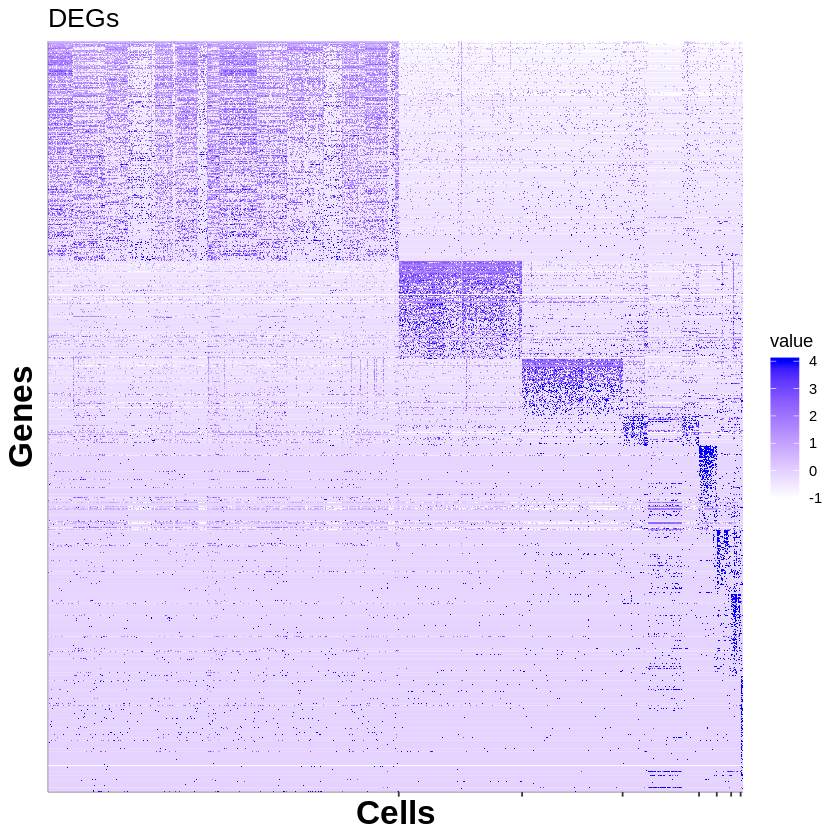

In [50]:

p <- ggplot(test.m, aes(Var2, Var1)) + geom_tile(aes(fill =value))+ scale_fill_continuous(limits=c(-1, 4), breaks=seq(-1,4,by=1),low = "white",high = "blue", oob=squish)+
scale_x_discrete(breaks=c(Oligo_barcode[1],Astrocyte_barcode[1],OPC_barcode[1],Microglia_barcode[1],Mural_barcode[1],Endothelial_barcode[1],Epen_barcode[1]))
# **colour = "white" at geom_tile may all white out the figure
pp<-p+ylab("Genes")+xlab("Cells")+theme(axis.text.x=element_blank(),axis.text.y=element_blank(),axis.title=element_text(size=20,face="bold"),plot.title = element_text(size=16),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black", size = 0.1),axis.ticks.y = element_blank())+ggtitle("DEGs")
print(pp)


# Ontology analysis

Ontology analysis utilized Enrichr https://amp.pharm.mssm.edu/Enrichr/

In [160]:
Neuron_BP<-read.table(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/conserved_markers_type/GO_Biological_Process_2018_table_Neuron.txt", header = TRUE, sep = "\t", quote = "\"",dec=".",fill=TRUE,comment.char="")
Neuron_MF<-read.table(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/conserved_markers_type/GO_Molecular_Function_2018_table_Neuron.txt", header = TRUE, sep = "\t", quote = "\"",dec=".",fill=TRUE,comment.char="")
Neuron_CC<-read.table(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/conserved_markers_type/GO_Cellular_Component_2018_table_Neuron.txt", header = TRUE, sep = "\t", quote = "\"",dec=".",fill=TRUE,comment.char="")
Neuron_BP<-Neuron_BP[order(Neuron_BP$Adjusted.P.value),]
Neuron_MF<-Neuron_MF[order(Neuron_MF$Adjusted.P.value),]
Neuron_CC<-Neuron_CC[order(Neuron_CC$Adjusted.P.value),]
Neuron_BP<-subset(Neuron_BP,Adjusted.P.value<0.1)
Neuron_MF<-subset(Neuron_MF,Adjusted.P.value<0.1)
Neuron_CC<-subset(Neuron_CC,Adjusted.P.value<0.1)
Neuron_BP$Term<-gsub('.{12}$','',as.character(Neuron_BP$Term))
Neuron_MF$Term<-gsub('.{12}$','',as.character(Neuron_MF$Term))
Neuron_CC$Term<-gsub('.{12}$','',as.character(Neuron_CC$Term))
fraction<-numeric()
for (i in 1:dim(Neuron_BP)[1]){
temp<-eval(parse(text=(as.character(Neuron_BP$Overlap[i])))) *100
fraction<-c(fraction,temp)
}
Neuron_BP$fraction<-fraction

fraction<-numeric()
for (i in 1:dim(Neuron_MF)[1]){
temp<-eval(parse(text=(as.character(Neuron_MF$Overlap[i])))) *100
fraction<-c(fraction,temp)
}
Neuron_MF$fraction<-fraction

fraction<-numeric()
for (i in 1:dim(Neuron_CC)[1]){
temp<-eval(parse(text=(as.character(Neuron_CC$Overlap[i])))) *100
fraction<-c(fraction,temp)
}
Neuron_CC$fraction<-fraction
neuron_BP<-Neuron_BP[,c(1,4,10)]
neuron_MF<-Neuron_MF[,c(1,4,10)]
neuron_CC<-Neuron_CC[,c(1,4,10)]

In [161]:
#top10
neuron_BP_s<-neuron_BP[1:10,]
neuron_MF_s<-neuron_MF[1:10,]
neuron_CC_s<-neuron_CC[1:9,]
neuron_BP_s<-neuron_BP_s[rev(order(neuron_BP_s$Adjusted.P.value)),]
neuron_BP_s$Term<-factor(neuron_BP_s$Term,levels=as.character(neuron_BP_s$Term))
neuron_BP_s$color<-rep("red",dim(neuron_BP_s)[1])
neuron_MF_s<-neuron_MF_s[rev(order(neuron_MF_s$Adjusted.P.value)),]
neuron_MF_s$Term<-factor(neuron_MF_s$Term,levels=as.character(neuron_MF_s$Term))
neuron_MF_s$color<-rep("green",dim(neuron_MF_s)[1])
neuron_CC_s<-neuron_CC_s[rev(order(neuron_CC_s$Adjusted.P.value)),]
neuron_CC_s$Term<-factor(neuron_CC_s$Term,levels=as.character(neuron_CC_s$Term))
neuron_CC_s$color<-rep("blue",dim(neuron_CC_s)[1])

In [162]:
neuron_all<-rbind(neuron_CC_s,neuron_MF_s,neuron_BP_s)

In [165]:
neuron_all

Term                                                                                             
10  acetylcholine-gated channel complex                                                              
11  intercalated disc                                                                                
6   node of Ranvier                                                                                  
9   main axon                                                                                        
4   G-protein coupled receptor dimeric complex                                                       
5   integral component of plasma membrane                                                            
3   dendrite membrane                                                                                
2   axon                                                                                             
1   dendrite                                                                                         
15  transmitter-gated ion channel activity involved in regulation of postsynaptic membrane potential 
101 voltage-gated sodium channel activity                                                            
91  voltage-gated ion channel activity involved in regulation of postsynaptic membrane potential     
41  cAMP-dependent protein kinase inhibitor activity                                                 
111 cation channel activity                                                                          
14  metal ion binding                                                                                
51  voltage-gated cation channel activity                                                            
21  syntaxin-1 binding                                                                               
12  calcium ion binding                                                                              
31  syntaxin binding                                                                                 
8   regulation of exocytosis                                                                         
20  axon development                                                                                 
16  nervous system development                                                                       
102 axon guidance                                                                                    
7   regulation of neurotransmitter secretion                                                         
42  regulation of secretion by cell                                                                  
61  modulation of chemical synaptic transmission                                                     
22  axonogenesis                                                                                     
32  anterograde trans-synaptic signaling                                                             
13  chemical synaptic transmission                                                                   
    Adjusted.P.value fraction  color
10  8.702522e-02     16.666667 blue 
11  6.943127e-02     12.500000 blue 
6   4.227225e-02     23.076923 blue 
9   1.538540e-02     14.705882 blue 
4   1.538540e-02     33.333333 blue 
5   1.128730e-04      3.825137 blue 
3   1.128730e-04     28.571429 blue 
2   8.210685e-11     14.788732 blue 
1   1.037629e-13     13.425926 blue 
15  4.028497e-03     16.216216 green
101 4.028497e-03     20.833333 green
91  4.028497e-03     20.833333 green
41  1.768925e-03     40.000000 green
111 6.223931e-04      8.843537 green
14  3.268141e-05      6.094808 green
51  1.267487e-05     12.871287 green
21  3.852153e-08     50.000000 green
12  6.464646e-09      9.473684 green
31  1.277226e-09     20.512821 green
8   1.310378e-05     19.230769 red  
20  1.360709e-06     14.736842 red  
16  9.697066e-07      6.798246 red  
102 9.697066e-07     11.320755 red  
7   7.312823e-07     32.142857 red  
42  4.283088e-07   

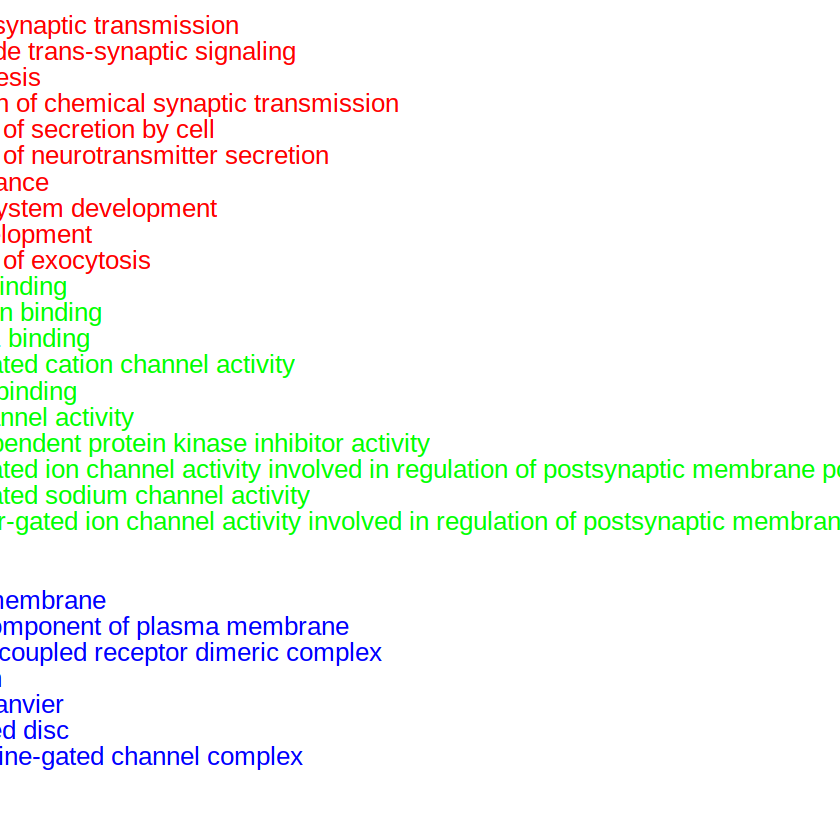

In [166]:
#col<-c("dark red","navy","yellow green","cyan","navy","dark red","navy","dark red","dark red","navy")
BP<- ggplot(neuron_all, aes(x=Term, y=fraction))+geom_bar(stat="identity")+ coord_flip()+ scale_y_reverse()+scale_x_discrete(position = "top") 
BP+theme(axis.title.y=element_blank(),
        ,axis.text.y=element_text(size=15,colour=neuron_all$color),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),legend.position = "none",
panel.background = element_blank(), axis.line = element_line(colour = "black"),axis.text.x=element_text(size=15,angle = 0, hjust = 0.5),axis.title.x=element_text(size=15))+ylab("Fraction (%)")
ggsave(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/conserved_markers_type/neuron_all.pdf",width=20,height=10)

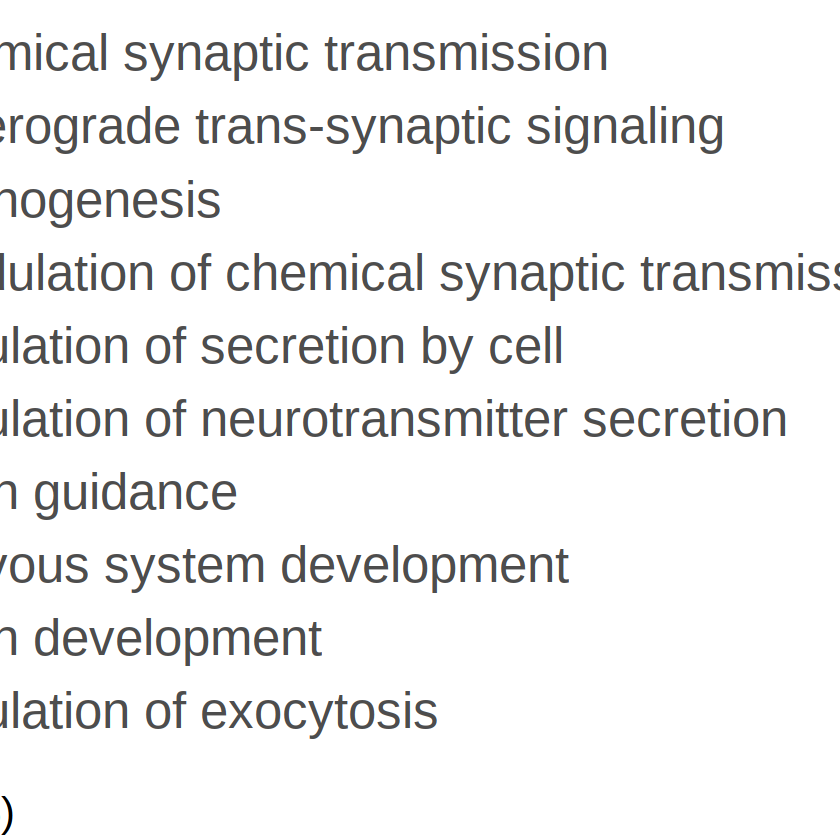

In [106]:
#col<-c("dark red","navy","yellow green","cyan","navy","dark red","navy","dark red","dark red","navy")
BP<- ggplot(neuron_BP_s, aes(x=Term, y=fraction))+geom_bar(stat="identity")+ coord_flip()+ scale_y_reverse()+scale_x_discrete(position = "top") 
BP+theme(axis.title.y=element_blank(),
        ,axis.text.y=element_text(size=30),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),legend.position = "none",
panel.background = element_blank(), axis.line = element_line(colour = "black"),axis.text.x=element_text(size=22,angle = 0, hjust = 0.5),axis.title.x=element_text(size=25))+ylab("Fraction (%)")
ggsave(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/conserved_markers_type/BP_top10_Neuron.pdf",width=14,height=8)

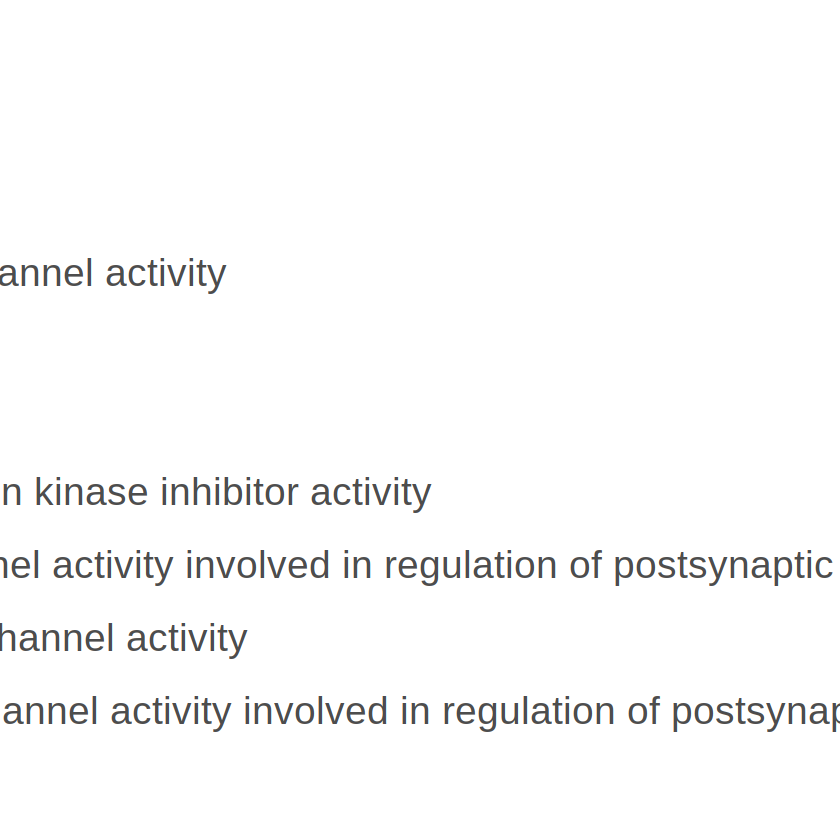

In [107]:
#col<-c("cyan","black","yellow green","yellow green","navy","black","cyan","black","dark red","dark red")
MF<- ggplot(neuron_MF_s, aes(x=Term, y=fraction))+geom_bar(stat="identity")+ coord_flip()+ scale_y_reverse()+scale_x_discrete(position = "top") 
MF+theme(axis.title.y=element_blank(),
        ,axis.text.y=element_text(size=23),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),legend.position = "none",
panel.background = element_blank(), axis.line = element_line(colour = "black"),axis.text.x=element_text(size=22,angle = 0, hjust = 0.5),axis.title.x=element_text(size=25))+ylab("Fraction (%)")
ggsave(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/conserved_markers_type/MF_top10_Neuron.pdf",width=20,height=8)

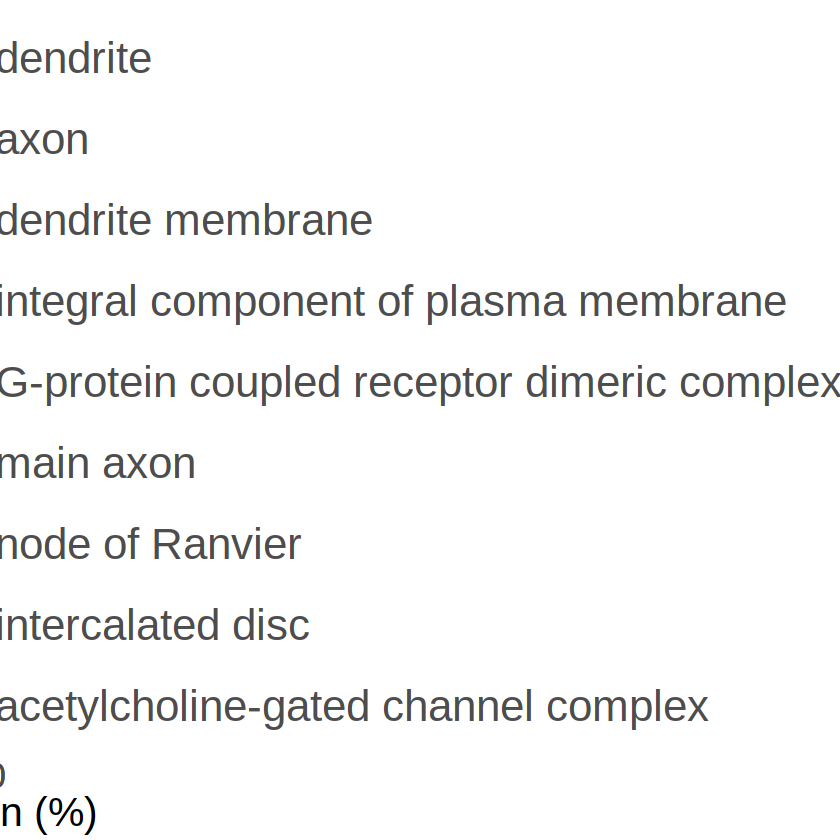

In [108]:
#col<-c("yellow green","dark red","navy","yellow green","yellow green","dark red","navy","navy","navy","dark red")
CC<- ggplot(neuron_CC_s, aes(x=Term, y=fraction))+geom_bar(stat="identity")+ coord_flip()+ scale_y_reverse()+scale_x_discrete(position = "top") 
CC+theme(axis.title.y=element_blank(),
        ,axis.text.y=element_text(size=26),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),legend.position = "none",
panel.background = element_blank(), axis.line = element_line(colour = "black"),axis.text.x=element_text(size=21,angle = 0, hjust = 0.5),axis.title.x=element_text(size=24))+ylab("Fraction (%)")
ggsave(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/conserved_markers_type/CC_top10_Neuron.pdf",width=14,height=8)

In [197]:
#Oligo
Oligo_BP<-read.table(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/conserved_markers_type/GO_Biological_Process_2018_table_Oligo.txt", header = TRUE, sep = "\t", quote = "\"",dec=".",fill=TRUE,comment.char="")
Oligo_MF<-read.table(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/conserved_markers_type/GO_Molecular_Function_2018_table_Oligo.txt", header = TRUE, sep = "\t", quote = "\"",dec=".",fill=TRUE,comment.char="")
Oligo_CC<-read.table(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/conserved_markers_type/GO_Cellular_Component_2018_table_Oligo.txt", header = TRUE, sep = "\t", quote = "\"",dec=".",fill=TRUE,comment.char="")
Oligo_BP<-Oligo_BP[order(Oligo_BP$Adjusted.P.value),]
Oligo_MF<-Oligo_MF[order(Oligo_MF$Adjusted.P.value),]
Oligo_CC<-Oligo_CC[order(Oligo_CC$Adjusted.P.value),]
Oligo_BP<-subset(Oligo_BP,Adjusted.P.value<0.1)
Oligo_MF<-subset(Oligo_MF,Adjusted.P.value<0.1)
Oligo_CC<-subset(Oligo_CC,Adjusted.P.value<0.1)
Oligo_BP$Term<-gsub('.{12}$','',as.character(Oligo_BP$Term))
Oligo_MF$Term<-gsub('.{12}$','',as.character(Oligo_MF$Term))
Oligo_CC$Term<-gsub('.{12}$','',as.character(Oligo_CC$Term))
fraction<-numeric()
for (i in 1:dim(Oligo_BP)[1]){
temp<-eval(parse(text=(as.character(Oligo_BP$Overlap[i])))) *100
fraction<-c(fraction,temp)
}
Oligo_BP$fraction<-fraction


fraction<-numeric()
for (i in 1:dim(Oligo_CC)[1]){
temp<-eval(parse(text=(as.character(Oligo_CC$Overlap[i])))) *100
fraction<-c(fraction,temp)
}
Oligo_CC$fraction<-fraction
Oligo_BP<-Oligo_BP[,c(1,4,10)]
#Oligo_MF<-Oligo_MF[,c(1,4,10)]
Oligo_CC<-Oligo_CC[,c(1,4,10)]

In [198]:
#top10
Oligo_BP_s<-Oligo_BP[1:10,]

Oligo_CC_s<-Oligo_CC[1:8,]
Oligo_BP_s<-Oligo_BP_s[rev(order(Oligo_BP_s$Adjusted.P.value)),]
Oligo_BP_s$Term<-factor(Oligo_BP_s$Term,levels=as.character(Oligo_BP_s$Term))

Oligo_CC_s<-Oligo_CC_s[rev(order(Oligo_CC_s$Adjusted.P.value)),]
Oligo_CC_s$Term<-factor(Oligo_CC_s$Term,levels=as.character(Oligo_CC_s$Term))

In [199]:
Oligo_BP_s$color<-rep("red",dim(Oligo_BP_s)[1])
#Oligo_MF_s$color<-rep("green",dim(Oligo_MF_s)[1])
Oligo_CC_s$color<-rep("blue",dim(Oligo_CC_s)[1])
Oligo_all<-rbind(Oligo_CC_s,Oligo_BP_s)

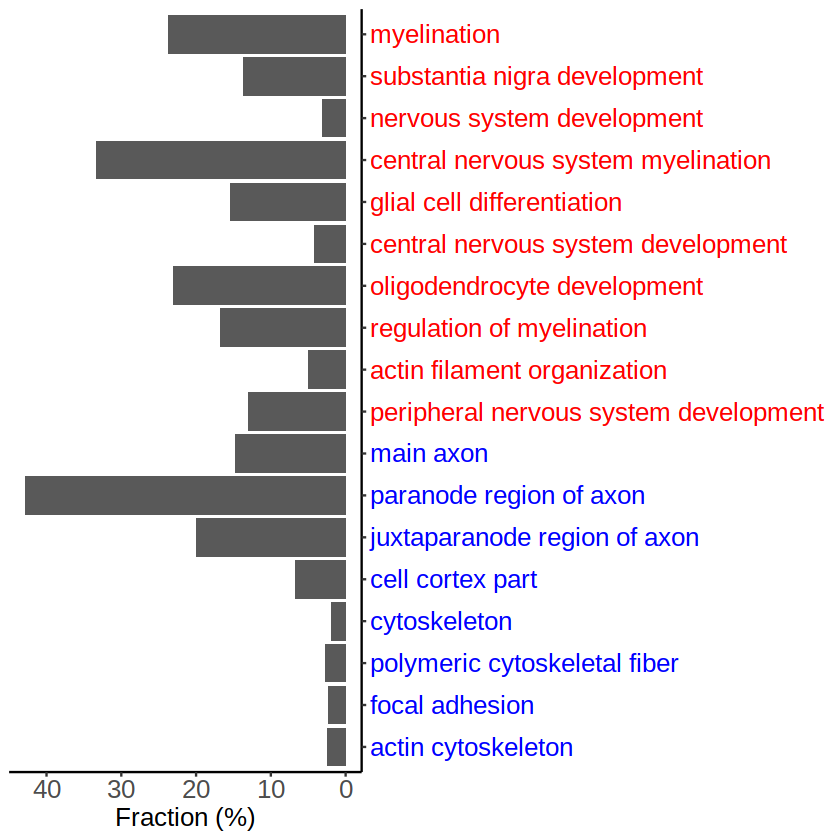

In [200]:
#col<-c("dark red","navy","yellow green","cyan","navy","dark red","navy","dark red","dark red","navy")
BP<- ggplot(Oligo_all, aes(x=Term, y=fraction))+geom_bar(stat="identity")+ coord_flip()+ scale_y_reverse()+scale_x_discrete(position = "top") 
BP+theme(axis.title.y=element_blank(),
        ,axis.text.y=element_text(size=15,colour=Oligo_all$color),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),legend.position = "none",
panel.background = element_blank(), axis.line = element_line(colour = "black"),axis.text.x=element_text(size=15,angle = 0, hjust = 0.5),axis.title.x=element_text(size=15))+ylab("Fraction (%)")
ggsave(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/conserved_markers_type/Oligo_all.pdf",width=20,height=10)

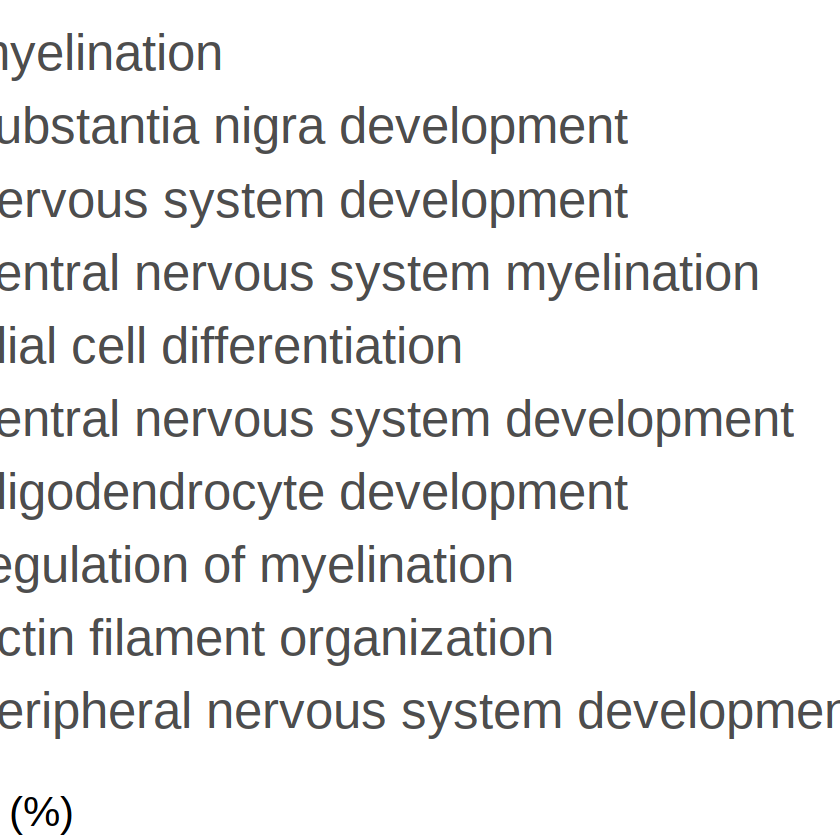

In [111]:
BP<- ggplot(Oligo_BP_s, aes(x=Term, y=fraction))+geom_bar(stat="identity")+ coord_flip()+ scale_y_reverse()+scale_x_discrete(position = "top") 
BP+theme(axis.title.y=element_blank(),
        ,axis.text.y=element_text(size=30),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),legend.position = "none",
panel.background = element_blank(), axis.line = element_line(colour = "black"),axis.text.x=element_text(size=22,angle = 0, hjust = 0.5),axis.title.x=element_text(size=25))+ylab("Fraction (%)")
ggsave(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/conserved_markers_type/BP_top10_Oligo.pdf",width=14,height=8)

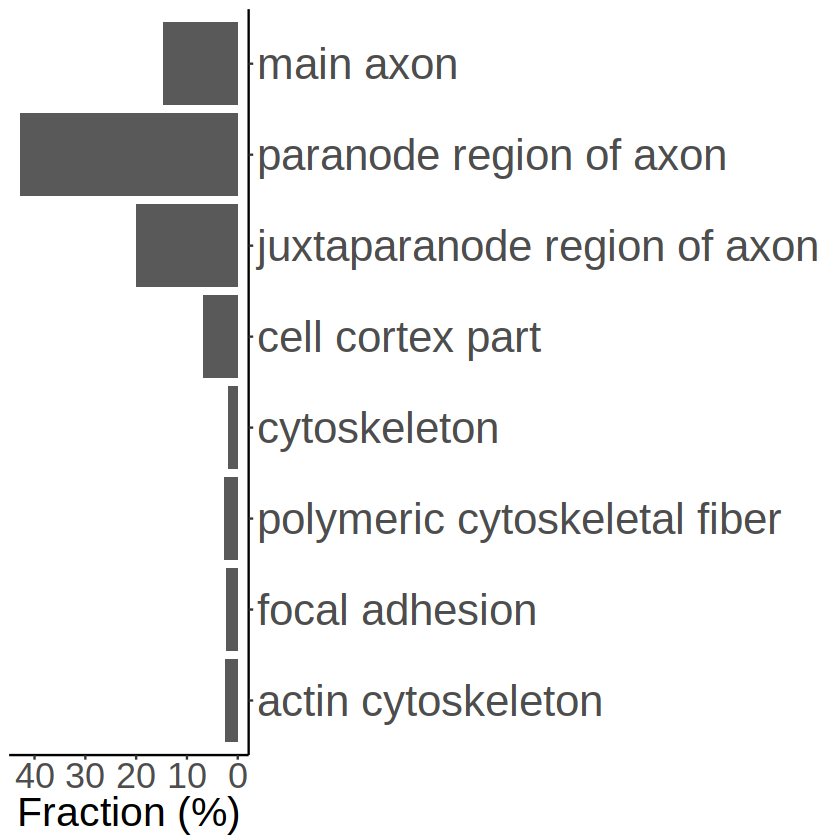

In [112]:
#col<-c("yellow green","dark red","navy","yellow green","yellow green","dark red","navy","navy","navy","dark red")
CC<- ggplot(Oligo_CC_s, aes(x=Term, y=fraction))+geom_bar(stat="identity")+ coord_flip()+ scale_y_reverse()+scale_x_discrete(position = "top") 
CC+theme(axis.title.y=element_blank(),
        ,axis.text.y=element_text(size=26),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),legend.position = "none",
panel.background = element_blank(), axis.line = element_line(colour = "black"),axis.text.x=element_text(size=21,angle = 0, hjust = 0.5),axis.title.x=element_text(size=24))+ylab("Fraction (%)")
ggsave(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/conserved_markers_type/CC_top10_Oligo.pdf",width=14,height=8)

In [205]:
Microglia_BP<-read.table(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/conserved_markers_type/GO_Biological_Process_2018_table_Microglia.txt", header = TRUE, sep = "\t", quote = "\"",dec=".",fill=TRUE,comment.char="")
Microglia_MF<-read.table(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/conserved_markers_type/GO_Molecular_Function_2018_table_Microglia.txt", header = TRUE, sep = "\t", quote = "\"",dec=".",fill=TRUE,comment.char="")
Microglia_CC<-read.table(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/conserved_markers_type/GO_Cellular_Component_2018_table_Microglia.txt", header = TRUE, sep = "\t", quote = "\"",dec=".",fill=TRUE,comment.char="")
Microglia_BP<-Microglia_BP[order(Microglia_BP$Adjusted.P.value),]
Microglia_MF<-Microglia_MF[order(Microglia_MF$Adjusted.P.value),]
Microglia_CC<-Microglia_CC[order(Microglia_CC$Adjusted.P.value),]
Microglia_BP<-subset(Microglia_BP,Adjusted.P.value<0.1)
Microglia_MF<-subset(Microglia_MF,Adjusted.P.value<0.1)
Microglia_CC<-subset(Microglia_CC,Adjusted.P.value<0.1)
Microglia_BP$Term<-gsub('.{12}$','',as.character(Microglia_BP$Term))
Microglia_MF$Term<-gsub('.{12}$','',as.character(Microglia_MF$Term))
Microglia_CC$Term<-gsub('.{12}$','',as.character(Microglia_CC$Term))
fraction<-numeric()
for (i in 1:dim(Microglia_BP)[1]){
temp<-eval(parse(text=(as.character(Microglia_BP$Overlap[i])))) *100
fraction<-c(fraction,temp)
}
Microglia_BP$fraction<-fraction

fraction<-numeric()
for (i in 1:dim(Microglia_MF)[1]){
temp<-eval(parse(text=(as.character(Microglia_MF$Overlap[i])))) *100
fraction<-c(fraction,temp)
}
Microglia_MF$fraction<-fraction

fraction<-numeric()
for (i in 1:dim(Microglia_CC)[1]){
temp<-eval(parse(text=(as.character(Microglia_CC$Overlap[i])))) *100
fraction<-c(fraction,temp)
}
Microglia_CC$fraction<-fraction
Microglia_BP<-Microglia_BP[,c(1,4,10)]
Microglia_MF<-Microglia_MF[,c(1,4,10)]
Microglia_CC<-Microglia_CC[,c(1,4,10)]

In [206]:
#top10
Microglia_BP_s<-Microglia_BP[1:10,]
Microglia_MF_s<-Microglia_MF[1:10,]
Microglia_CC_s<-Microglia_CC[1:10,]
Microglia_BP_s<-Microglia_BP_s[rev(order(Microglia_BP_s$Adjusted.P.value)),]
Microglia_BP_s$Term<-factor(Microglia_BP_s$Term,levels=as.character(Microglia_BP_s$Term))
Microglia_MF_s<-Microglia_MF_s[rev(order(Microglia_MF_s$Adjusted.P.value)),]
Microglia_MF_s$Term<-factor(Microglia_MF_s$Term,levels=as.character(Microglia_MF_s$Term))
Microglia_CC_s<-Microglia_CC_s[rev(order(Microglia_CC_s$Adjusted.P.value)),]
Microglia_CC_s$Term<-factor(Microglia_CC_s$Term,levels=as.character(Microglia_CC_s$Term))


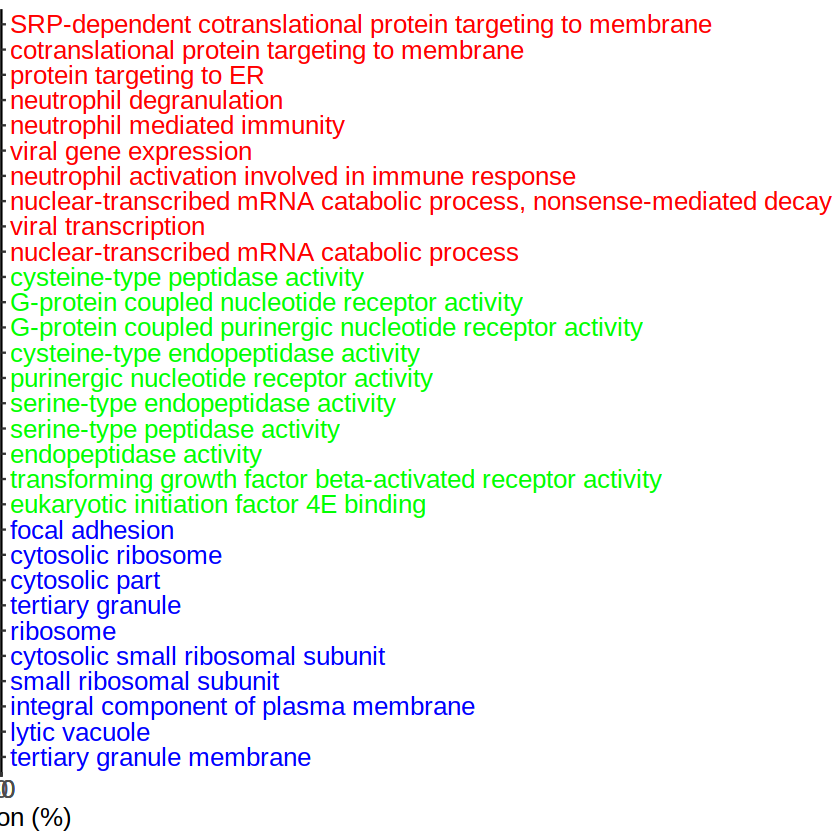

In [207]:
Microglia_BP_s$color<-rep("red",dim(Microglia_BP_s)[1])
Microglia_MF_s$color<-rep("green",dim(Microglia_MF_s)[1])
Microglia_CC_s$color<-rep("blue",dim(Microglia_CC_s)[1])
Microglia_all<-rbind(Microglia_CC_s,Microglia_MF_s,Microglia_BP_s)

BP<- ggplot(Microglia_all, aes(x=Term, y=fraction))+geom_bar(stat="identity")+ coord_flip()+ scale_y_reverse()+scale_x_discrete(position = "top") 
BP+theme(axis.title.y=element_blank(),
        ,axis.text.y=element_text(size=15,colour=Microglia_all$color),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),legend.position = "none",
panel.background = element_blank(), axis.line = element_line(colour = "black"),axis.text.x=element_text(size=15,angle = 0, hjust = 0.5),axis.title.x=element_text(size=15))+ylab("Fraction (%)")
ggsave(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/conserved_markers_type/Microglia_all.pdf",width=20,height=10)

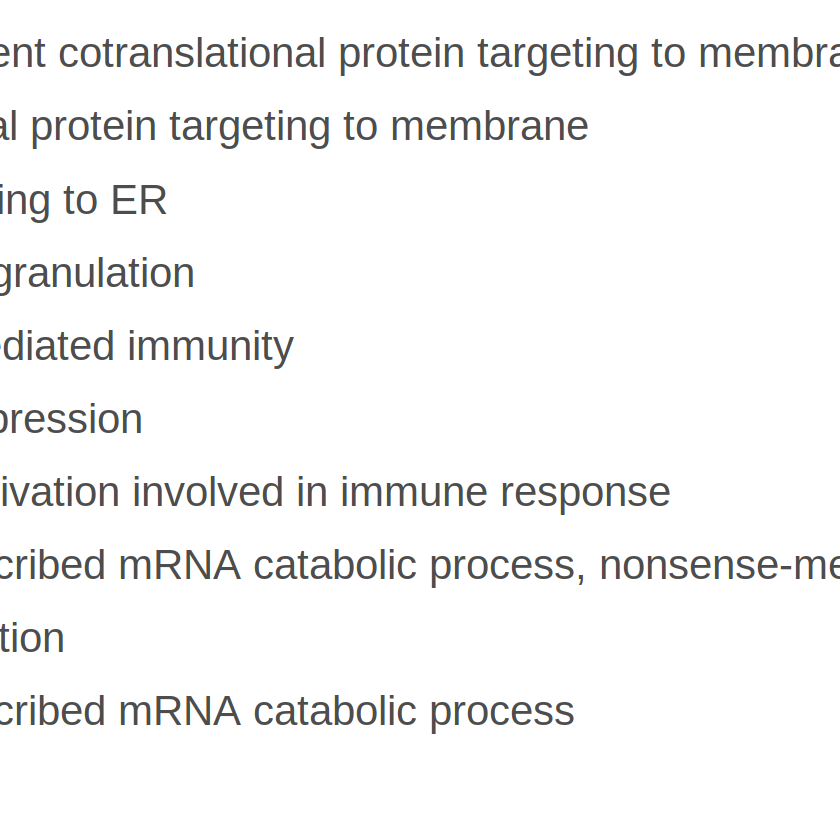

In [128]:
BP<- ggplot(Microglia_BP_s, aes(x=Term, y=fraction))+geom_bar(stat="identity")+ coord_flip()+ scale_y_reverse()+scale_x_discrete(position = "top") 
BP+theme(axis.title.y=element_blank(),
        ,axis.text.y=element_text(size=25),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),legend.position = "none",
panel.background = element_blank(), axis.line = element_line(colour = "black"),axis.text.x=element_text(size=22,angle = 0, hjust = 0.5),axis.title.x=element_text(size=25))+ylab("Fraction (%)")
ggsave(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/conserved_markers_type/BP_top10_Microglia.pdf",width=14,height=8)

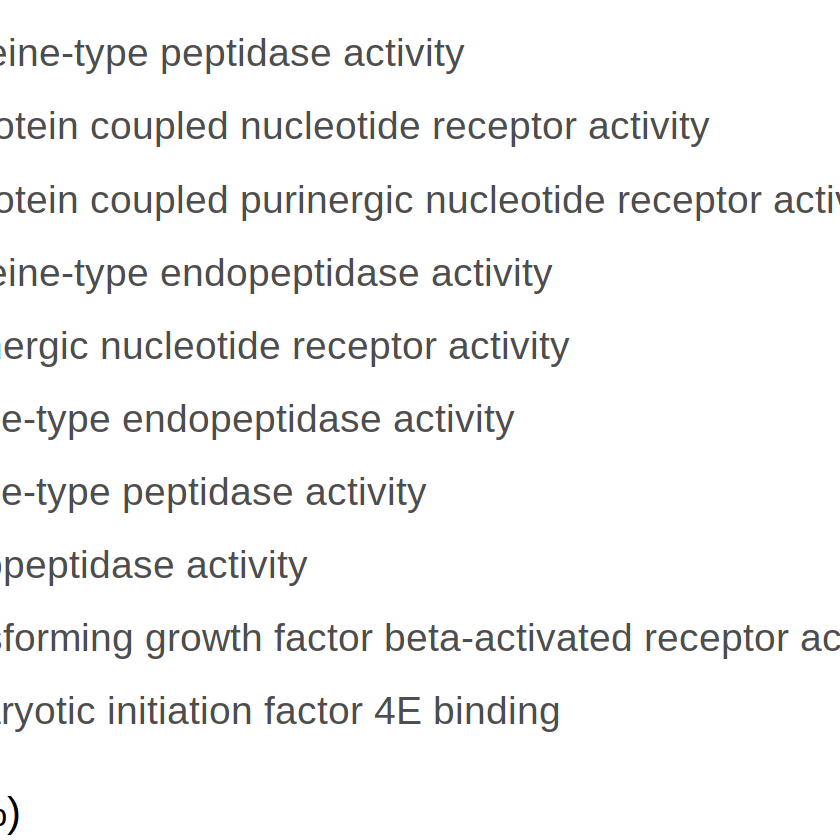

In [129]:
#col<-c("cyan","black","yellow green","yellow green","navy","black","cyan","black","dark red","dark red")
MF<- ggplot(Microglia_MF_s, aes(x=Term, y=fraction))+geom_bar(stat="identity")+ coord_flip()+ scale_y_reverse()+scale_x_discrete(position = "top") 
MF+theme(axis.title.y=element_blank(),
        ,axis.text.y=element_text(size=23),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),legend.position = "none",
panel.background = element_blank(), axis.line = element_line(colour = "black"),axis.text.x=element_text(size=22,angle = 0, hjust = 0.5),axis.title.x=element_text(size=25))+ylab("Fraction (%)")
ggsave(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/conserved_markers_type/MF_top10_Microglia.pdf",width=20,height=8)

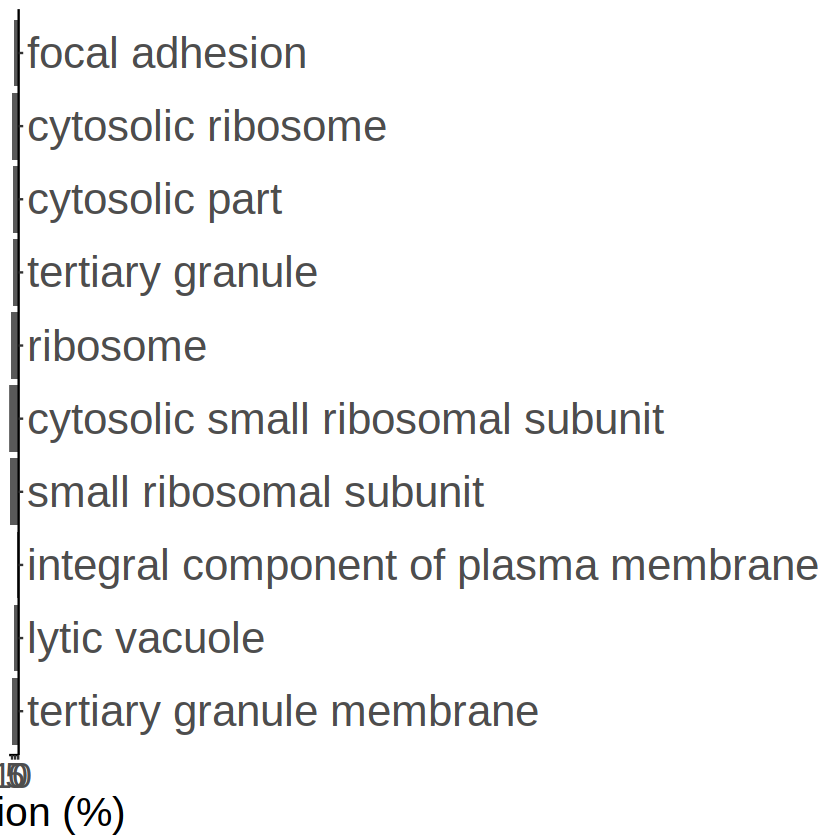

In [130]:
#col<-c("yellow green","dark red","navy","yellow green","yellow green","dark red","navy","navy","navy","dark red")
CC<- ggplot(Microglia_CC_s, aes(x=Term, y=fraction))+geom_bar(stat="identity")+ coord_flip()+ scale_y_reverse()+scale_x_discrete(position = "top") 
CC+theme(axis.title.y=element_blank(),
        ,axis.text.y=element_text(size=26),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),legend.position = "none",
panel.background = element_blank(), axis.line = element_line(colour = "black"),axis.text.x=element_text(size=21,angle = 0, hjust = 0.5),axis.title.x=element_text(size=24))+ylab("Fraction (%)")
ggsave(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/conserved_markers_type/CC_top10_Microglia.pdf",width=14,height=8)

In [208]:
Astrocyte_BP<-read.table(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/conserved_markers_type/GO_Biological_Process_2018_table_Astrocyte.txt", header = TRUE, sep = "\t", quote = "\"",dec=".",fill=TRUE,comment.char="")
Astrocyte_MF<-read.table(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/conserved_markers_type/GO_Molecular_Function_2018_table_Astrocyte.txt", header = TRUE, sep = "\t", quote = "\"",dec=".",fill=TRUE,comment.char="")
Astrocyte_CC<-read.table(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/conserved_markers_type/GO_Cellular_Component_2018_table_Astrocyte.txt", header = TRUE, sep = "\t", quote = "\"",dec=".",fill=TRUE,comment.char="")
Astrocyte_BP<-Astrocyte_BP[order(Astrocyte_BP$Adjusted.P.value),]
Astrocyte_MF<-Astrocyte_MF[order(Astrocyte_MF$Adjusted.P.value),]
Astrocyte_CC<-Astrocyte_CC[order(Astrocyte_CC$Adjusted.P.value),]
Astrocyte_BP<-subset(Astrocyte_BP,Adjusted.P.value<0.1)
Astrocyte_MF<-subset(Astrocyte_MF,Adjusted.P.value<0.1)
Astrocyte_CC<-subset(Astrocyte_CC,Adjusted.P.value<0.1)
Astrocyte_BP$Term<-gsub('.{12}$','',as.character(Astrocyte_BP$Term))
Astrocyte_MF$Term<-gsub('.{12}$','',as.character(Astrocyte_MF$Term))
Astrocyte_CC$Term<-gsub('.{12}$','',as.character(Astrocyte_CC$Term))
fraction<-numeric()
for (i in 1:dim(Astrocyte_BP)[1]){
temp<-eval(parse(text=(as.character(Astrocyte_BP$Overlap[i])))) *100
fraction<-c(fraction,temp)
}
Astrocyte_BP$fraction<-fraction

fraction<-numeric()
for (i in 1:dim(Astrocyte_MF)[1]){
temp<-eval(parse(text=(as.character(Astrocyte_MF$Overlap[i])))) *100
fraction<-c(fraction,temp)
}
Astrocyte_MF$fraction<-fraction

fraction<-numeric()
for (i in 1:dim(Astrocyte_CC)[1]){
temp<-eval(parse(text=(as.character(Astrocyte_CC$Overlap[i])))) *100
fraction<-c(fraction,temp)
}
Astrocyte_CC$fraction<-fraction
Astrocyte_BP<-Astrocyte_BP[,c(1,4,10)]
Astrocyte_MF<-Astrocyte_MF[,c(1,4,10)]
Astrocyte_CC<-Astrocyte_CC[,c(1,4,10)]

In [209]:
#top10
Astrocyte_BP_s<-Astrocyte_BP[1:10,]
Astrocyte_MF_s<-Astrocyte_MF[1:10,]
Astrocyte_CC_s<-Astrocyte_CC[1:10,]
Astrocyte_BP_s<-Astrocyte_BP_s[rev(order(Astrocyte_BP_s$Adjusted.P.value)),]
Astrocyte_BP_s$Term<-factor(Astrocyte_BP_s$Term,levels=as.character(Astrocyte_BP_s$Term))
Astrocyte_MF_s<-Astrocyte_MF_s[rev(order(Astrocyte_MF_s$Adjusted.P.value)),]
Astrocyte_MF_s$Term<-factor(Astrocyte_MF_s$Term,levels=as.character(Astrocyte_MF_s$Term))
Astrocyte_CC_s<-Astrocyte_CC_s[rev(order(Astrocyte_CC_s$Adjusted.P.value)),]
Astrocyte_CC_s$Term<-factor(Astrocyte_CC_s$Term,levels=as.character(Astrocyte_CC_s$Term))

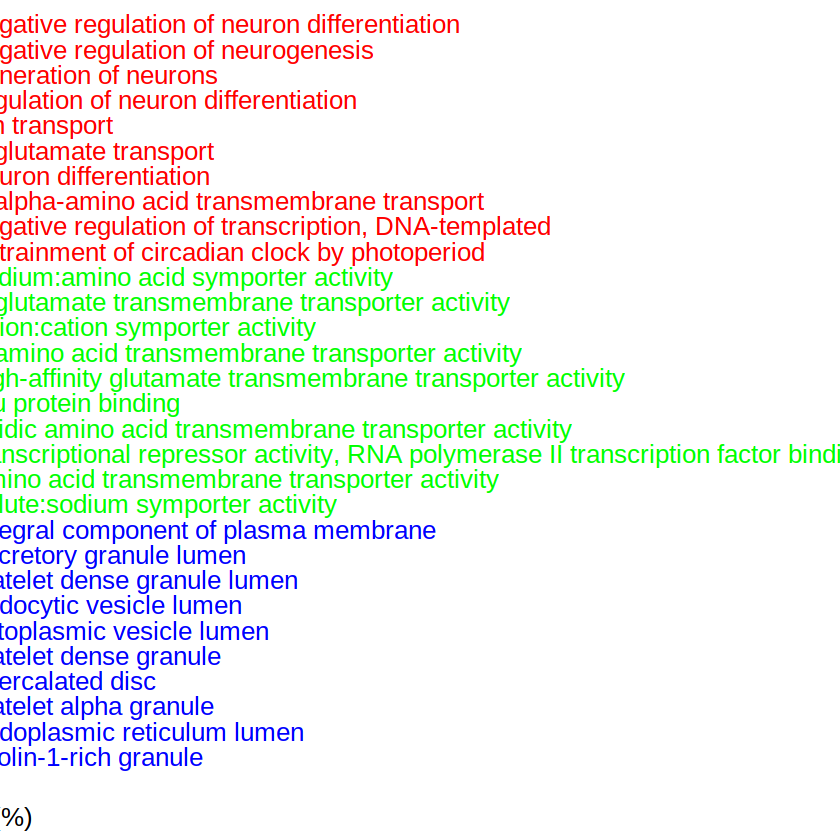

In [210]:
Astrocyte_BP_s$color<-rep("red",dim(Astrocyte_BP_s)[1])
Astrocyte_MF_s$color<-rep("green",dim(Astrocyte_MF_s)[1])
Astrocyte_CC_s$color<-rep("blue",dim(Astrocyte_CC_s)[1])
Astrocyte_all<-rbind(Astrocyte_CC_s,Astrocyte_MF_s,Astrocyte_BP_s)

BP<- ggplot(Astrocyte_all, aes(x=Term, y=fraction))+geom_bar(stat="identity")+ coord_flip()+ scale_y_reverse()+scale_x_discrete(position = "top") 
BP+theme(axis.title.y=element_blank(),
        ,axis.text.y=element_text(size=15,colour=Astrocyte_all$color),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),legend.position = "none",
panel.background = element_blank(), axis.line = element_line(colour = "black"),axis.text.x=element_text(size=15,angle = 0, hjust = 0.5),axis.title.x=element_text(size=15))+ylab("Fraction (%)")
ggsave(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/conserved_markers_type/Astrocyte_all.pdf",width=20,height=10)

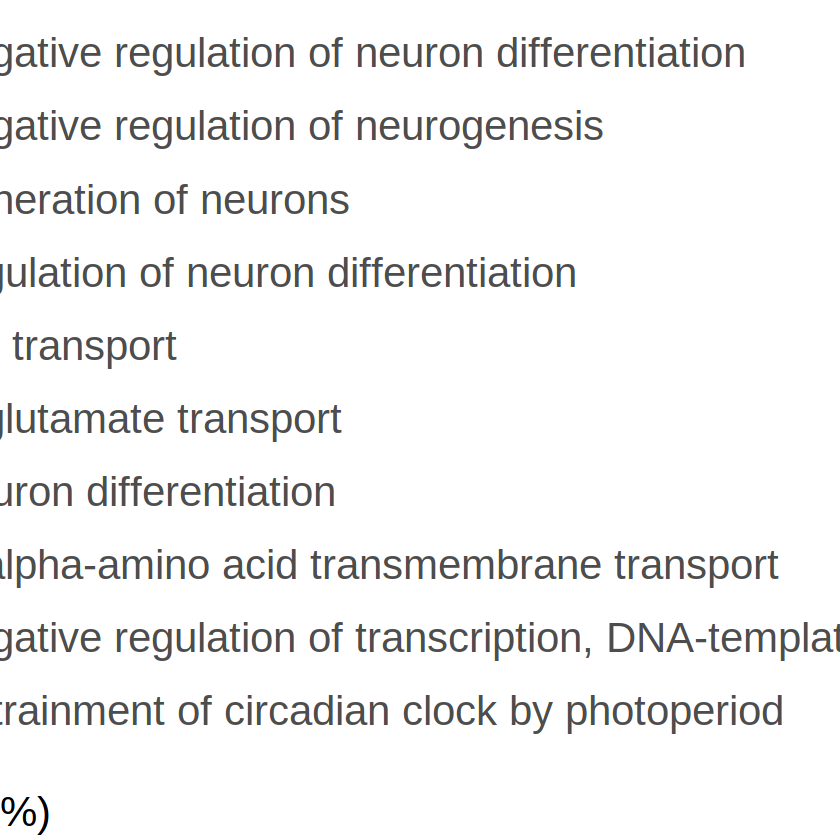

In [122]:
BP<- ggplot(Astrocyte_BP_s, aes(x=Term, y=fraction))+geom_bar(stat="identity")+ coord_flip()+ scale_y_reverse()+scale_x_discrete(position = "top") 
BP+theme(axis.title.y=element_blank(),
        ,axis.text.y=element_text(size=25),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),legend.position = "none",
panel.background = element_blank(), axis.line = element_line(colour = "black"),axis.text.x=element_text(size=22,angle = 0, hjust = 0.5),axis.title.x=element_text(size=25))+ylab("Fraction (%)")
ggsave(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/conserved_markers_type/BP_top10_Astrocyte.pdf",width=14,height=8)

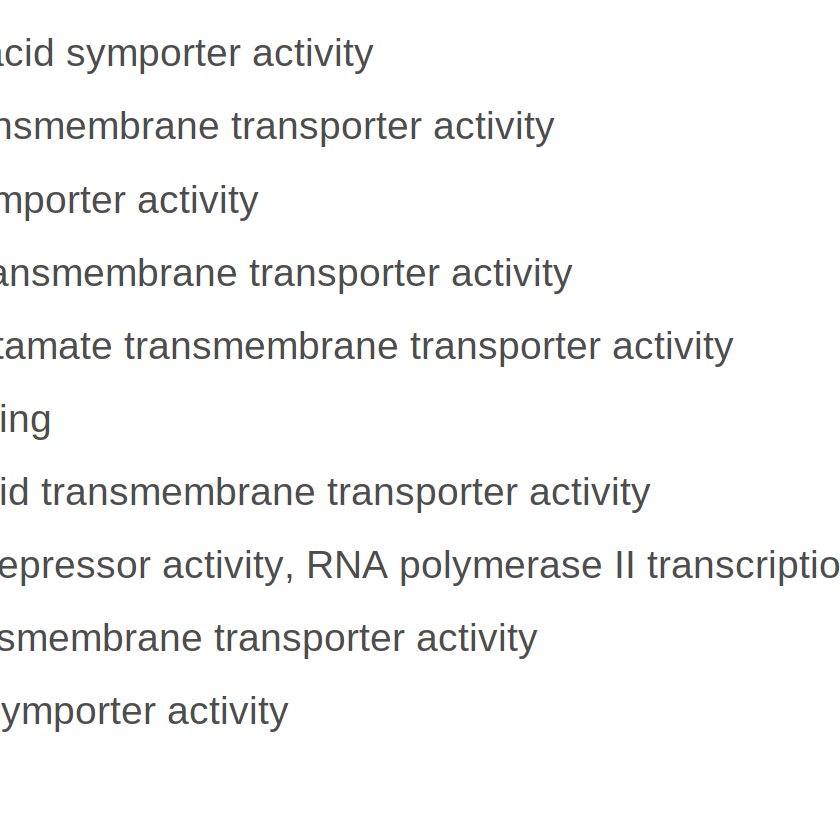

In [123]:
#col<-c("cyan","black","yellow green","yellow green","navy","black","cyan","black","dark red","dark red")
MF<- ggplot(Astrocyte_MF_s, aes(x=Term, y=fraction))+geom_bar(stat="identity")+ coord_flip()+ scale_y_reverse()+scale_x_discrete(position = "top") 
MF+theme(axis.title.y=element_blank(),
        ,axis.text.y=element_text(size=23),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),legend.position = "none",
panel.background = element_blank(), axis.line = element_line(colour = "black"),axis.text.x=element_text(size=22,angle = 0, hjust = 0.5),axis.title.x=element_text(size=25))+ylab("Fraction (%)")
ggsave(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/conserved_markers_type/MF_top10_Astrocyte.pdf",width=20,height=8)

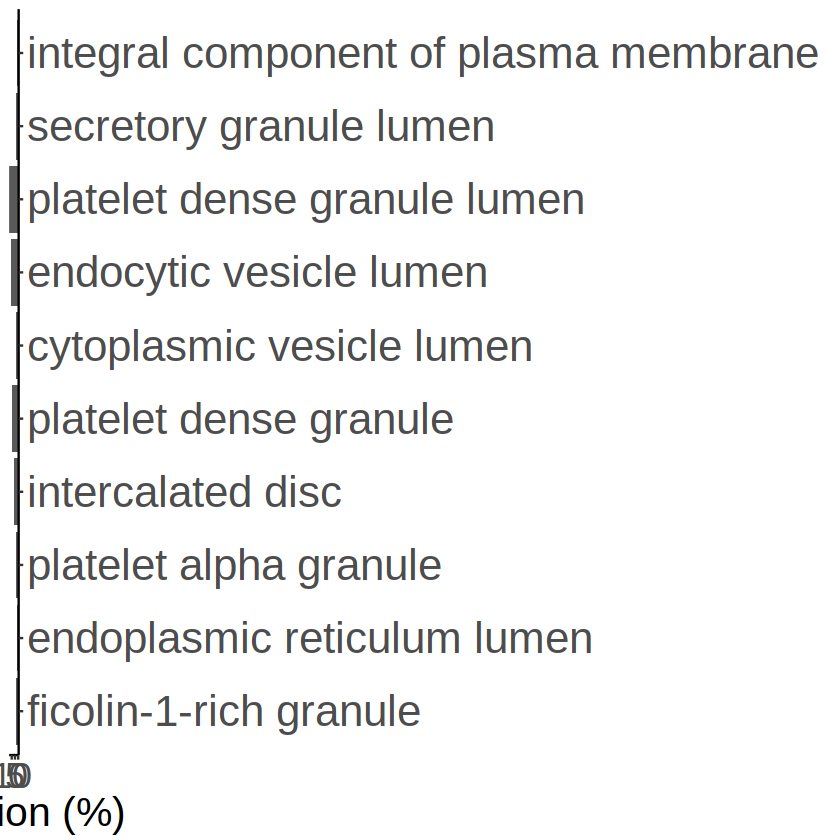

In [124]:
#col<-c("yellow green","dark red","navy","yellow green","yellow green","dark red","navy","navy","navy","dark red")
CC<- ggplot(Astrocyte_CC_s, aes(x=Term, y=fraction))+geom_bar(stat="identity")+ coord_flip()+ scale_y_reverse()+scale_x_discrete(position = "top") 
CC+theme(axis.title.y=element_blank(),
        ,axis.text.y=element_text(size=26),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),legend.position = "none",
panel.background = element_blank(), axis.line = element_line(colour = "black"),axis.text.x=element_text(size=21,angle = 0, hjust = 0.5),axis.title.x=element_text(size=24))+ylab("Fraction (%)")
ggsave(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/conserved_markers_type/CC_top10_Astrocyte.pdf",width=14,height=8)

In [211]:
OPC_BP<-read.table(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/conserved_markers_type/GO_Biological_Process_2018_table_OPC.txt", header = TRUE, sep = "\t", quote = "\"",dec=".",fill=TRUE,comment.char="")
OPC_MF<-read.table(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/conserved_markers_type/GO_Molecular_Function_2018_table_OPC.txt", header = TRUE, sep = "\t", quote = "\"",dec=".",fill=TRUE,comment.char="")
OPC_CC<-read.table(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/conserved_markers_type/GO_Cellular_Component_2018_table_OPC.txt", header = TRUE, sep = "\t", quote = "\"",dec=".",fill=TRUE,comment.char="")
OPC_BP<-OPC_BP[order(OPC_BP$Adjusted.P.value),]
OPC_MF<-OPC_MF[order(OPC_MF$Adjusted.P.value),]
OPC_CC<-OPC_CC[order(OPC_CC$Adjusted.P.value),]
OPC_BP<-subset(OPC_BP,Adjusted.P.value<0.1)
OPC_MF<-subset(OPC_MF,Adjusted.P.value<0.1)
OPC_CC<-subset(OPC_CC,Adjusted.P.value<0.1)
OPC_BP$Term<-gsub('.{12}$','',as.character(OPC_BP$Term))
OPC_MF$Term<-gsub('.{12}$','',as.character(OPC_MF$Term))
OPC_CC$Term<-gsub('.{12}$','',as.character(OPC_CC$Term))
fraction<-numeric()
for (i in 1:dim(OPC_BP)[1]){
temp<-eval(parse(text=(as.character(OPC_BP$Overlap[i])))) *100
fraction<-c(fraction,temp)
}
OPC_BP$fraction<-fraction

fraction<-numeric()
for (i in 1:dim(OPC_MF)[1]){
temp<-eval(parse(text=(as.character(OPC_MF$Overlap[i])))) *100
fraction<-c(fraction,temp)
}
OPC_MF$fraction<-fraction

fraction<-numeric()
for (i in 1:dim(OPC_CC)[1]){
temp<-eval(parse(text=(as.character(OPC_CC$Overlap[i])))) *100
fraction<-c(fraction,temp)
}
OPC_CC$fraction<-fraction
OPC_BP<-OPC_BP[,c(1,4,10)]
OPC_MF<-OPC_MF[,c(1,4,10)]
OPC_CC<-OPC_CC[,c(1,4,10)]

In [212]:
OPC_BP_s<-OPC_BP[1:10,]
OPC_MF_s<-OPC_MF[1:4,]
OPC_CC_s<-OPC_CC[1:3,]
OPC_BP_s<-OPC_BP_s[rev(order(OPC_BP_s$Adjusted.P.value)),]
OPC_BP_s$Term<-factor(OPC_BP_s$Term,levels=as.character(OPC_BP_s$Term))
OPC_MF_s<-OPC_MF_s[rev(order(OPC_MF_s$Adjusted.P.value)),]
OPC_MF_s$Term<-factor(OPC_MF_s$Term,levels=as.character(OPC_MF_s$Term))
OPC_CC_s<-OPC_CC_s[rev(order(OPC_CC_s$Adjusted.P.value)),]
OPC_CC_s$Term<-factor(OPC_CC_s$Term,levels=as.character(OPC_CC_s$Term))

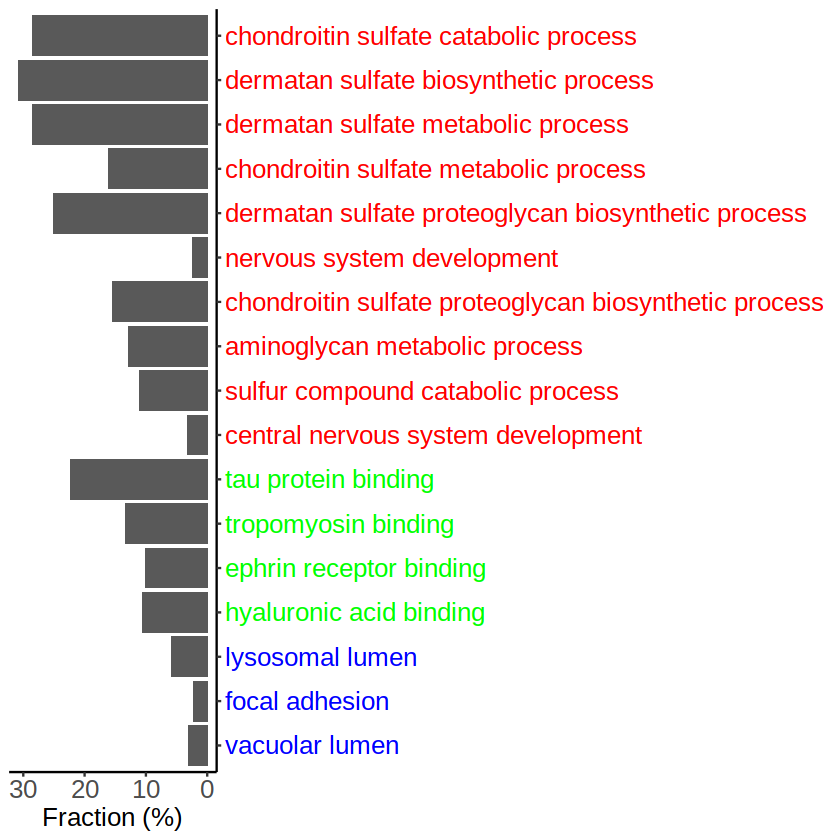

In [213]:
OPC_BP_s$color<-rep("red",dim(OPC_BP_s)[1])
OPC_MF_s$color<-rep("green",dim(OPC_MF_s)[1])
OPC_CC_s$color<-rep("blue",dim(OPC_CC_s)[1])
OPC_all<-rbind(OPC_CC_s,OPC_MF_s,OPC_BP_s)

BP<- ggplot(OPC_all, aes(x=Term, y=fraction))+geom_bar(stat="identity")+ coord_flip()+ scale_y_reverse()+scale_x_discrete(position = "top") 
BP+theme(axis.title.y=element_blank(),
        ,axis.text.y=element_text(size=15,colour=OPC_all$color),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),legend.position = "none",
panel.background = element_blank(), axis.line = element_line(colour = "black"),axis.text.x=element_text(size=15,angle = 0, hjust = 0.5),axis.title.x=element_text(size=15))+ylab("Fraction (%)")
ggsave(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/conserved_markers_type/OPC_all.pdf",width=20,height=10)

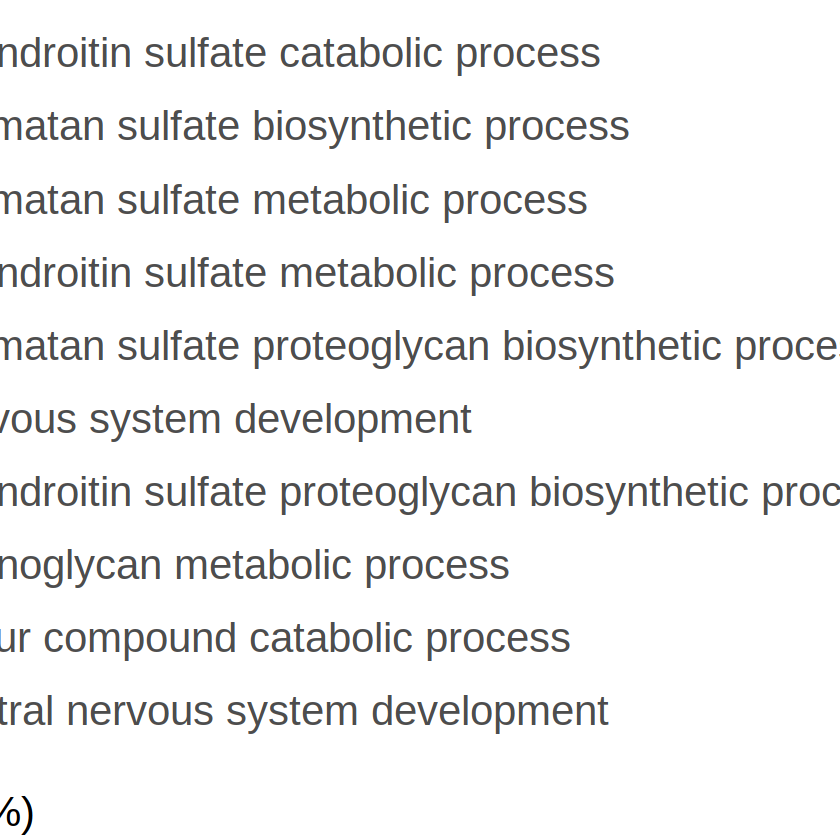

In [135]:
BP<- ggplot(OPC_BP_s, aes(x=Term, y=fraction))+geom_bar(stat="identity")+ coord_flip()+ scale_y_reverse()+scale_x_discrete(position = "top") 
BP+theme(axis.title.y=element_blank(),
        ,axis.text.y=element_text(size=25),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),legend.position = "none",
panel.background = element_blank(), axis.line = element_line(colour = "black"),axis.text.x=element_text(size=22,angle = 0, hjust = 0.5),axis.title.x=element_text(size=25))+ylab("Fraction (%)")
ggsave(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/conserved_markers_type/BP_top10_OPC.pdf",width=14,height=8)

In [137]:
OPC_MF

Term                     Adjusted.P.value fraction
1 tau protein binding      0.07557939       22.22222
4 tropomyosin binding      0.09688154       13.33333
5 ephrin receptor binding  0.09688154       10.00000
7 hyaluronic acid binding  0.09688154       10.52632

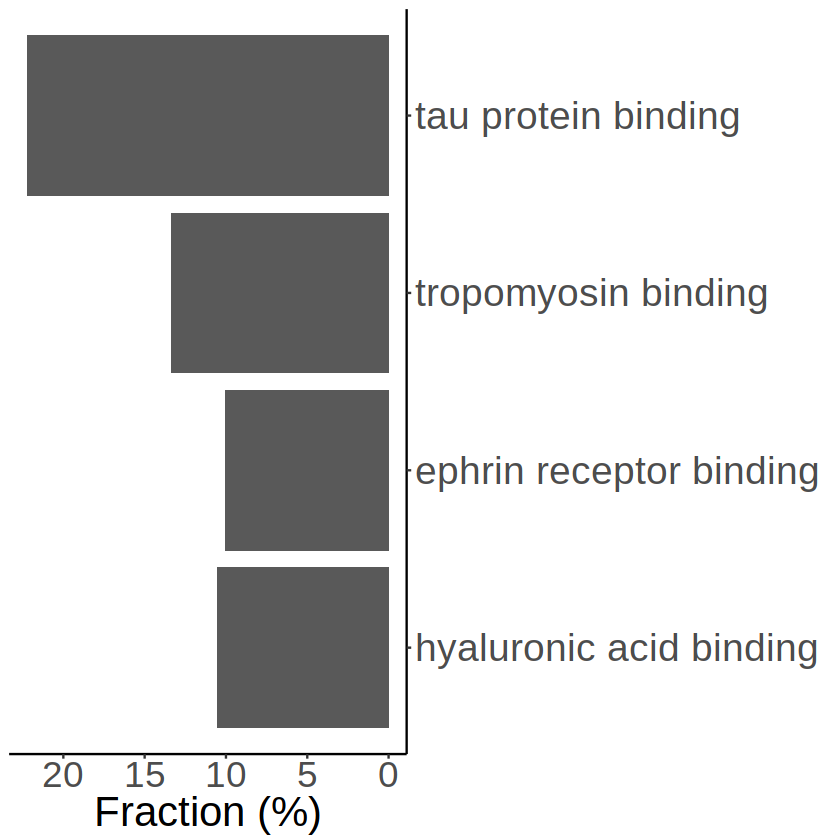

In [140]:
#col<-c("cyan","black","yellow green","yellow green","navy","black","cyan","black","dark red","dark red")
MF<- ggplot(OPC_MF_s, aes(x=Term, y=fraction))+geom_bar(stat="identity")+ coord_flip()+ scale_y_reverse()+scale_x_discrete(position = "top") 
MF+theme(axis.title.y=element_blank(),
        ,axis.text.y=element_text(size=23),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),legend.position = "none",
panel.background = element_blank(), axis.line = element_line(colour = "black"),axis.text.x=element_text(size=22,angle = 0, hjust = 0.5),axis.title.x=element_text(size=25))+ylab("Fraction (%)")
ggsave(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/conserved_markers_type/MF_top10_OPC.pdf",width=20,height=8)

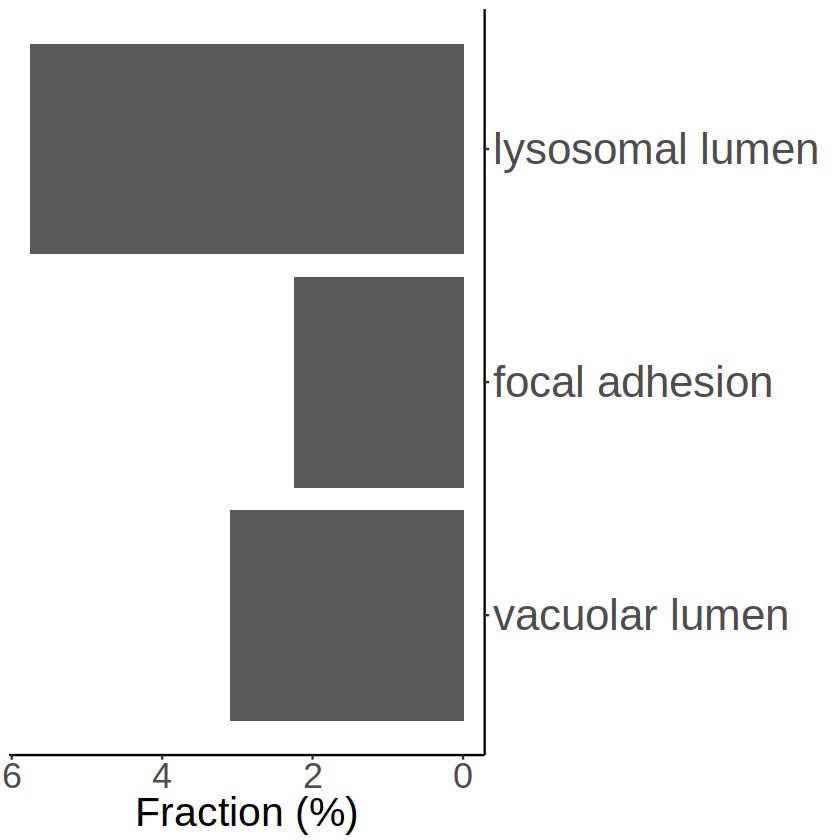

In [141]:
#col<-c("yellow green","dark red","navy","yellow green","yellow green","dark red","navy","navy","navy","dark red")
CC<- ggplot(OPC_CC_s, aes(x=Term, y=fraction))+geom_bar(stat="identity")+ coord_flip()+ scale_y_reverse()+scale_x_discrete(position = "top") 
CC+theme(axis.title.y=element_blank(),
        ,axis.text.y=element_text(size=26),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),legend.position = "none",
panel.background = element_blank(), axis.line = element_line(colour = "black"),axis.text.x=element_text(size=21,angle = 0, hjust = 0.5),axis.title.x=element_text(size=24))+ylab("Fraction (%)")
ggsave(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/conserved_markers_type/CC_top10_OPC.pdf",width=14,height=8)


# analyze number of cell in each cluster

# simple version with one value for one cluster, number of cells

In [47]:
# separate by stimulus condition
Cell_type<-c("Neuron","Oligo","Astrocyte","OPC","Microglia","Mural","Endothelial","Epen")
#Cell_type<-c("Astrocyte1","Oligo1","Neuron1","Neuron2","Neuron3","Neuron4","Neuron5","Neuron6","OPC1","OPC2","Oligo2","Neuron7","Microglia","Neuron8","Mural","Endotherial","OPC3","Oligo3","Astrocyte2","Eppen")
# make a data frame for cell number (this data frame is a simple version giving single value for each cluster) 
Cell_number<- data.frame("type" =c(Cell_type,Cell_type), "Cond" = c(rep("cntl",length(Cell_type)),rep("stim",length(Cell_type))))
# be careful with how you define factor and levels
as.factor(Cell_number$type)
levels(Cell_number$type)<-c("Neuron","Oligo","Astrocyte","OPC","Microglia","Mural","Endothelial","Epen")
as.factor(Cell_number$Cond)

Numberofcells<-vector(mode="numeric", length=0)
proportion<-vector(mode="numeric", length=0)

for (i in 1:dim(Cell_number)[1]){Numberofcells[i]<-length(eval(parse(text = paste(Cell_number$type[i],"_barcode","_",Cell_number$Cond[i],sep=""))))}
Cell_number$len<-Numberofcells

for (i in 1:dim(Cell_number)[1]){if (Cell_number$Cond[i]=="cntl"){proportion[i]<-100*length(eval(parse(text = paste(Cell_number$type[i],"_barcode","_",Cell_number$Cond[i],sep=""))))/sum(Cell_number$len[grep("cntl",Cell_number$Cond)])} else {proportion[i]<-100*length(eval(parse(text = paste(Cell_number$type[i],"_barcode","_",Cell_number$Cond[i],sep=""))))/sum(Cell_number$len[grep("stim",Cell_number$Cond)])}}
Cell_number$prop<-proportion

[1] Neuron      Oligo       Astrocyte   OPC         Microglia   Mural      
 [7] Endothelial Epen        Neuron      Oligo       Astrocyte   OPC        
[13] Microglia   Mural       Endothelial Epen       
Levels: Astrocyte Endothelial Epen Microglia Mural Neuron Oligo OPC

[1] cntl cntl cntl cntl cntl cntl cntl cntl stim stim stim stim stim stim stim
[16] stim
Levels: cntl stim

png 
  2

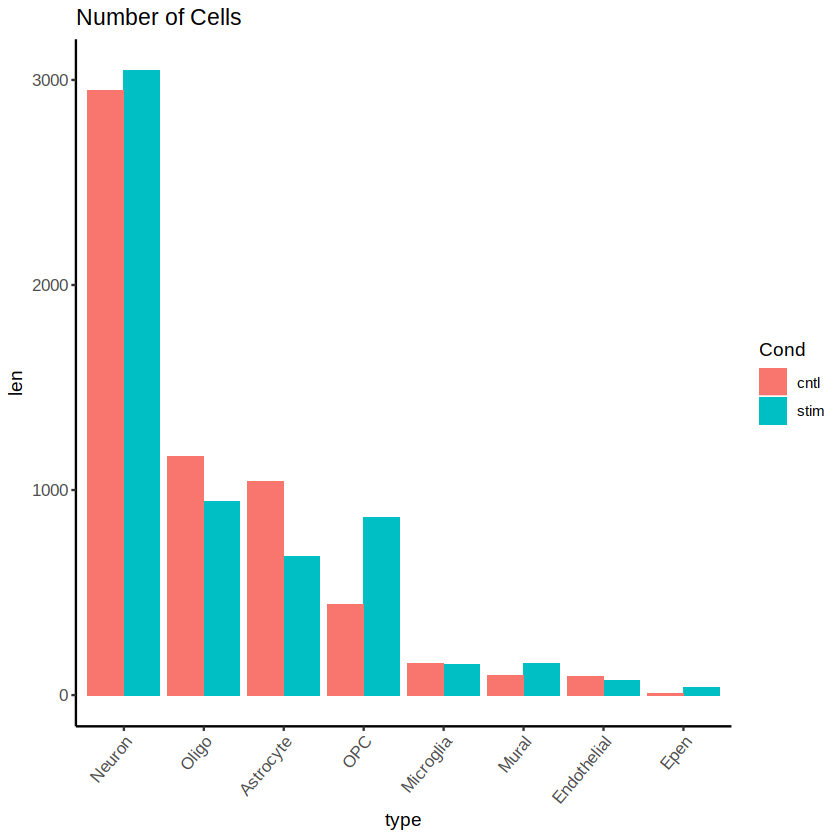

In [48]:
# number of cells in each cluster
ggplot(Cell_number,aes(x=type,y=len,fill=Cond))+geom_bar(stat = "identity",position=position_dodge())+theme(axis.text.y=element_text(size=10),axis.text.x=element_text(size=10,angle = 50, hjust = 1),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"))+ggtitle("Number of Cells")
dev.copy2pdf(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/number of cells.pdf")

png 
  2

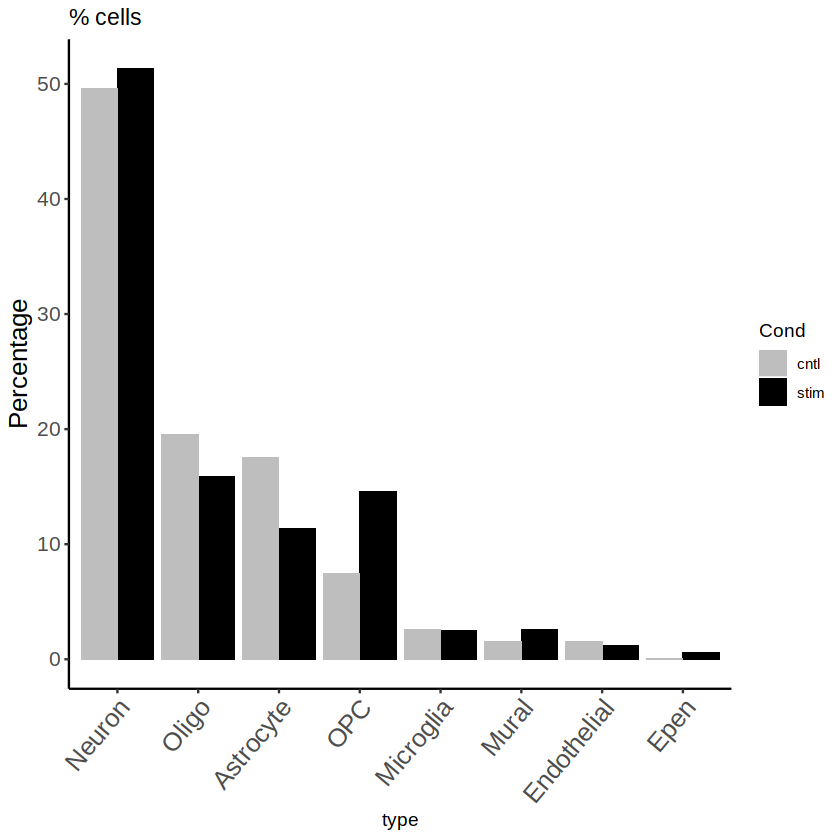

In [49]:
# proportion of cells
ggplot(Cell_number,aes(x=type,y=proportion,fill=Cond))+geom_bar(stat = "identity",position=position_dodge())+ylab("Percentage")+scale_fill_manual(values=c("grey", "black"))+theme(axis.title.y=element_text(size=15),axis.text.y=element_text(size=12),axis.text.x=element_text(size=15,angle = 50, hjust = 1),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"))+ggtitle("% cells")
dev.copy2pdf(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/percent of cells.pdf")

## combine condition, but in each cluster

In [182]:
Cell_type<-c("Oligo3","Oligo1","Oligo2","Neuron4","Neuron2","Neuron8","Neuron3","Neuron6","Neuron1","Neuron5","Neuron7","Microglia","Eppen","Astrocyte1","Astrocyte2","OPC3","OPC1","OPC2","Mural","Endotherial")
# make a data frame for cell number (this data frame is a simple version giving single value for each cluster) 
Cell_number<- data.frame("type" =Cell_type)
# be careful with how you define factor and levels
as.factor(Cell_number$type)
levels(Cell_number$type)<-c("Oligo3","Oligo1","Oligo2","Neuron4","Neuron2","Neuron8","Neuron3","Neuron6","Neuron1","Neuron5","Neuron7","Microglia","Eppen","Astrocyte1","Astrocyte2","OPC3","OPC1","OPC2","Mural","Endotherial")

Numberofcells<-vector(mode="numeric", length=0)
proportion<-vector(mode="numeric", length=0)

for (i in 1:dim(Cell_number)[1]){Numberofcells[i]<-length(eval(parse(text = paste(Cell_number$type[i],"_barcode",sep=""))))}
Cell_number$len<-Numberofcells

for (i in 1:dim(Cell_number)[1]){proportion[i]<-100*length(eval(parse(text = paste(Cell_number$type[i],"_barcode",sep=""))))/sum(Cell_number$len)}
Cell_number$prop<-proportion

[1] Oligo3      Oligo1      Oligo2      Neuron4     Neuron2     Neuron8    
 [7] Neuron3     Neuron6     Neuron1     Neuron5     Neuron7     Microglia  
[13] Eppen       Astrocyte1  Astrocyte2  OPC3        OPC1        OPC2       
[19] Mural       Endotherial
20 Levels: Astrocyte1 Astrocyte2 Endotherial Eppen Microglia Mural ... OPC3

In [183]:
colors<-c("#ffc857","#ffc857","#ffc857","#9B0C1E","#9B0C1E","#9B0C1E","#9B0C1E","#9B0C1E","#9B0C1E","#9B0C1E","#9B0C1E","#676833","#B99A69","#19647e","#19647e","#4b3f72","#4b3f72","#4b3f72","#b7b7b7","#E8C6C7")

png 
  2

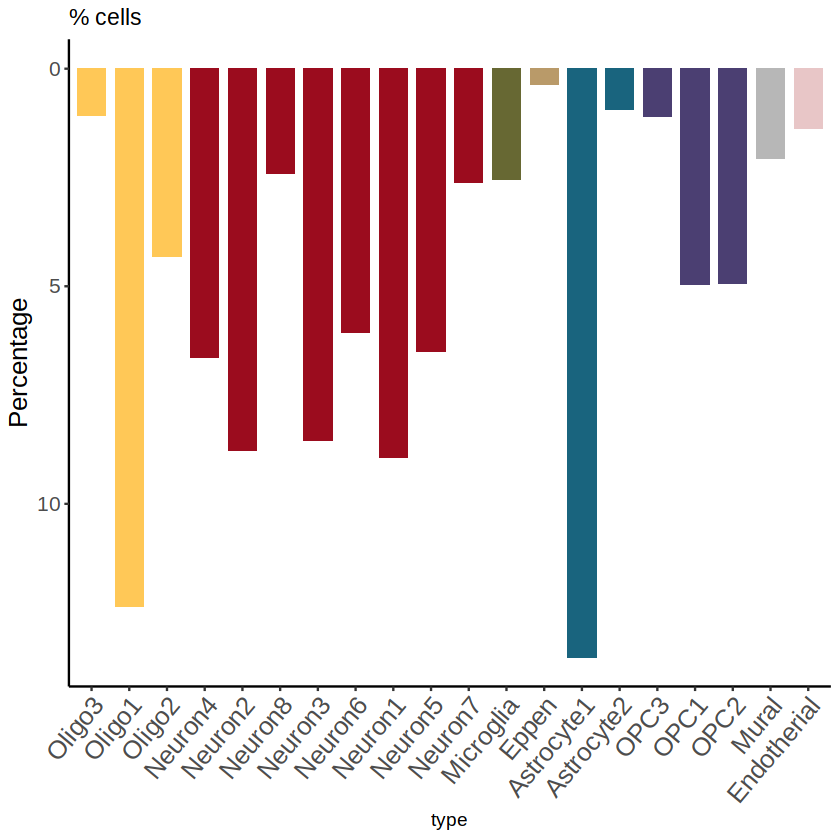

In [184]:
# proportion of cells
ggplot(Cell_number,aes(x=type,y=proportion,fill=Cell_type, width=.75))+geom_bar(stat = "identity",position=position_dodge())+ylab("Percentage")+
#scale_fill_manual(values=c("Astrocyte1"="#19647e","Oligo1"="#ffc857","Neuron1"="#9B0C1E","Neuron2"="#9B0C1E","Neuron3"="#9B0C1E","Neuron4"="#9B0C1E","Neuron5"="#9B0C1E","Neuron6"="#9B0C1E","OPC1"="#4b3f72","OPC2"="#4b3f72","Oligo2"="#ffc857","Neuron7"="#9B0C1E","Microglia"="#676833","Neuron8"="#9B0C1E","Mural"="#b7b7b7","Endotherial"="#E8C6C7","OPC3"="#4b3f72","Oligo3"="#ffc857","Astrocyte2"="#19647e","Eppen"="#B99A69"))+ 
scale_fill_manual(values=colors)+
scale_y_reverse()+
theme(legend.position="none",axis.title.y=element_text(size=15),axis.text.y=element_text(size=12),axis.text.x=element_text(size=15,angle = 50, hjust = 1),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"))+ggtitle("% cells")
dev.copy2pdf(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/percent of cells_combine_percluster.pdf",height=6, width=10 , paper = "letter")